In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import gaussian_kde, kurtosis, skew, norm
from prophet import Prophet
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import BayesianOptimization
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')


# Global definitions for column names and units
COLUMNS = {
    'daily': ['TMAX', 'TAVG', 'TMIN', 'PRCP', 'SNWD'],
    'monthly': ['EMXP', 'EMXT', 'DSND', 'PRCP', 'DX90', 'DP10', 'HDSD', 'HTDD', 'DX70', 'DP01', 'CDSD', 'EMNT', 'DT32', 'DT00', 'DX32', 'CLDD', 'TMAX', 'EMSD', 'TAVG', 'TMIN'],
    'yearly': ['EMXP', 'EMXT', 'PRCP', 'DX90', 'DP10', 'DX70', 'EMNT', 'DT32', 'DX32', 'TMAX', 'EMSD', 'TAVG', 'TMIN']
}

COLUMN_NAMES = {
    'daily': ['Maximum Temperature', 'Average Temperature', 'Minimum Temperature', 'Precipitation', 'Snow Depth'],
    'monthly': ['Extreme Maximum Precipitation', 'Extreme Maximum Temperature', 'Number of Days with Snow Depth > 1 inch',
                'Precipitation', 'Number of Days with Maximum Temperature > 90°F', 'Number of Days with >= 1.0 inch of Precipitation',
                'Heating Degree Days Season to Date', 'Heating Degree Days', 'Number of Days with Maximum Temperature > 70°F',
                'Number of Days with >= 0.1 inch of Precipitation', 'Cooling Degree Days Season to Date', 'Extreme Minimum Temperature',
                'Number of Days with Minimum Temperature <= 32°F', 'Number of Days with Minimum Temperature <= 0.0°F',
                'Number of Days with Maximum Temperature < 32°F', 'Cooling Degree Days', 'Maximum Temperature',
                'Extreme Maximum Snow Depth', 'Average Temperature', 'Minimum Temperature'],
    'yearly': ['Extreme Maximum Precipitation', 'Extreme Maximum Temperature', 'Precipitation', 'Number of Days with Maximum Temperature > 90°F',
               'Number of Days with >= 1.0 inch of Precipitation', 'Number of Days with Maximum Temperature > 70°F',
               'Extreme Minimum Temperature', 'Number of Days with Minimum Temperature <= 32°F',
               'Number of Days with Maximum Temperature < 32°F', 'Maximum Temperature', 'Extreme Maximum Snow Depth',
               'Average Temperature', 'Minimum Temperature']
}

UNITS = {
    'daily': ['°C', '°C', '°C', 'mm', 'mm'],
    'monthly': ['mm', '°C', 'days', 'mm', 'days', 'days', 'degree-days', 'degree-days', 'days', 'days', 'degree-days', '°C', 'days', 'days', 'days', 'degree-days', '°C', 'mm', '°C', '°C'],
    'yearly': ['mm', '°C', 'mm', 'days', 'days', 'days', '°C', 'days', 'days', '°C', 'mm', '°C', '°C']
}

# Global variables to hold datasets
daily_data = None
monthly_data = None
yearly_data = None

def fill_na_with_mean(df):
    """Fills NA values in numeric columns with the column mean."""
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        mean_value = df[col].mean()
        df[col] = df[col].fillna(mean_value)
    return df

def load_dataset(filepath):
    """Loads a dataset from the specified file path and handles exceptions."""
    try:
        df = pd.read_csv(filepath, parse_dates=['DATE'], index_col='DATE')
        return df.sort_index()
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None
    except pd.errors.ParserError as e:
        print(f"Parsing error: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None

def preprocess_data(df):
    """Preprocesses the data by filling NA values with the mean and sorting by date."""
    df = fill_na_with_mean(df)
    return df.sort_index()

def load_and_preprocess_data():
    """Loads and preprocesses daily, monthly, and yearly datasets."""
    global daily_data, monthly_data, yearly_data
    
    daily_data = load_dataset('Daily Summaries - GHCND.csv')
    monthly_data = load_dataset('Global Summary of the Month - GSOM.csv')
    yearly_data = load_dataset('Global Summary of The Year - GSOY.csv')
    
    if daily_data is not None:
        daily_data = preprocess_data(daily_data)
    if monthly_data is not None:
        monthly_data = preprocess_data(monthly_data)
    if yearly_data is not None:
        yearly_data = preprocess_data(yearly_data)


def main():
    """Main function to execute the data loading and preprocessing."""
    load_and_preprocess_data()

    if daily_data is None or monthly_data is None or yearly_data is None:
        print("Data loading failed. Please check the file paths and formats.")
    else:
        print("Data loaded and preprocessed successfully.")

# Execute the main function
if __name__ == "__main__":
    main()


Data loaded and preprocessed successfully.


/var/folders/_w/z212vp356g34lvt4w9pyhrvc0000gn/T/ipykernel_33645/838991402.py:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


Top 5 Stations based on the highest average maximum temperature (TMAX):
    STATION                  NAME      TMAX     TMIN        PRCP        SNWD
UKE00156884            WISLEY, UK 16.027401 6.878126 3096.429792 1781.247337
UKE00105648 CAMBRIDGE B. GDNS, UK 15.747696 6.869636 2766.284013 1716.975525
UKE00105923              HURN, UK 15.719016 6.671778 4019.629792    0.000000
UKE00107962         YEOVILTON, UK 15.545936 6.887084 3308.800000 1781.247337
UKM00003772          HEATHROW, UK 15.489456 7.318098 2980.777547 1948.303484


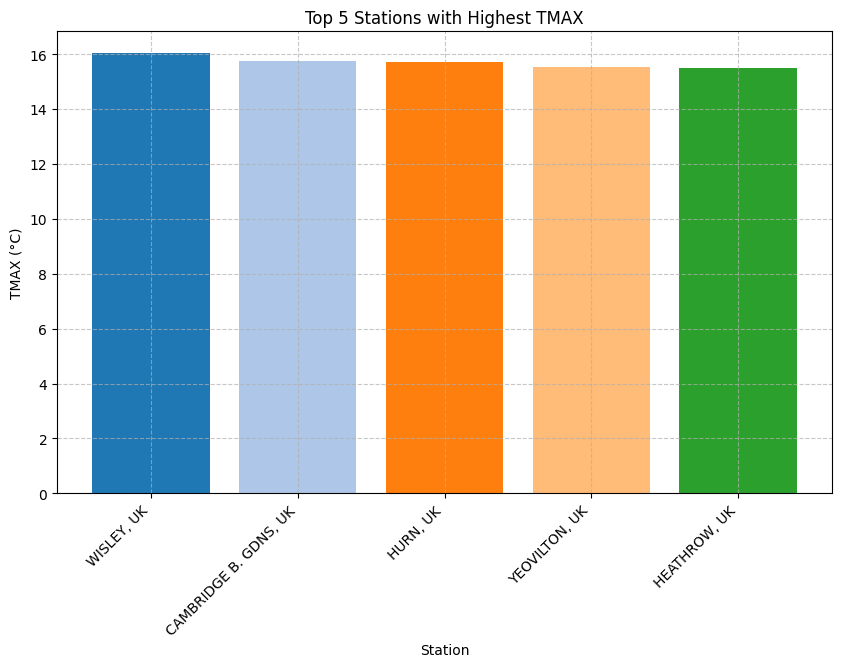


Top 5 Stations based on the highest average minimum temperature (TMIN):
    STATION                          NAME      TMAX     TMIN        PRCP        SNWD
UKE00156880 WIGHT ST CATHERINES POINT, UK 14.097878 9.572654 3451.392225 1781.247337
UKE00105869                   SWANAGE, UK 14.751168 9.020747 3894.195509 1781.247337
UK000003808                  CAMBORNE, UK 14.137688 8.977448 4965.195509  139.691333
UKE00105921                  HASTINGS, UK 14.599714 8.962440 3628.829792 1747.963720
UKE00105873                      BUDE, UK 14.776370 8.524582 3870.728150 1781.247337


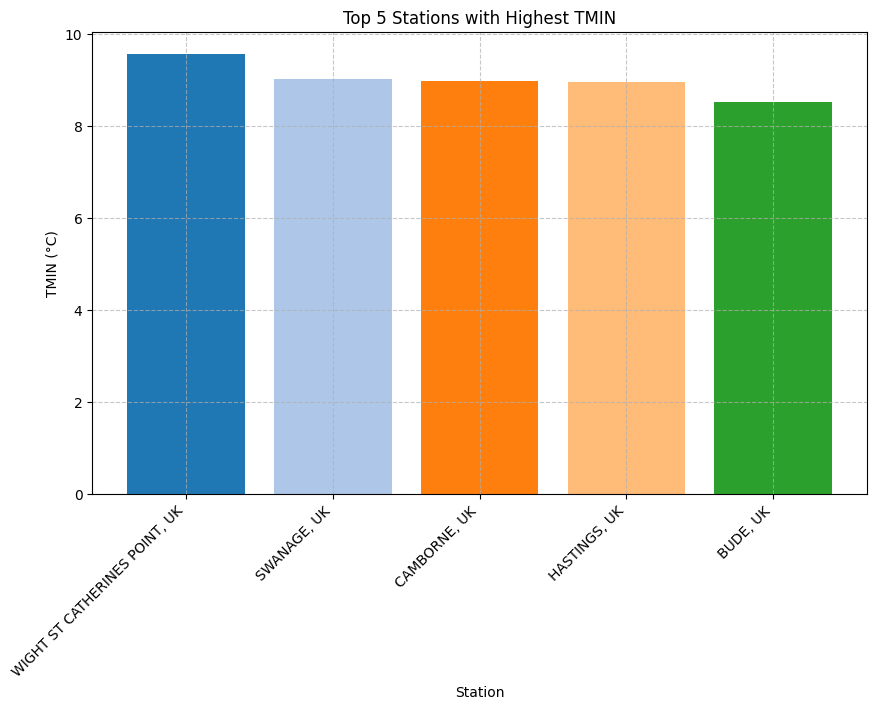


Top 5 Stations based on the highest total precipitation (PRCP):
    STATION                              NAME      TMAX     TMIN        PRCP        SNWD
UKE00105913                    KINLOCHEWE, UK 12.922353 5.286421 9381.750603 1749.111431
UKE00105930 BENMORE YOUNGER BOTANIC GARDE, UK 12.713844 5.554624 9039.711830 1397.911892
UK000003162                   ESKDALEMUIR, UK 12.070805 4.306458 8900.543264 4001.225166
UK000047811                        ARMAGH, UK 13.072113 7.614165 7574.844493 1490.876476
UKE00105905                        BUXTON, UK 12.285495 5.634217 6618.786528 1781.247337


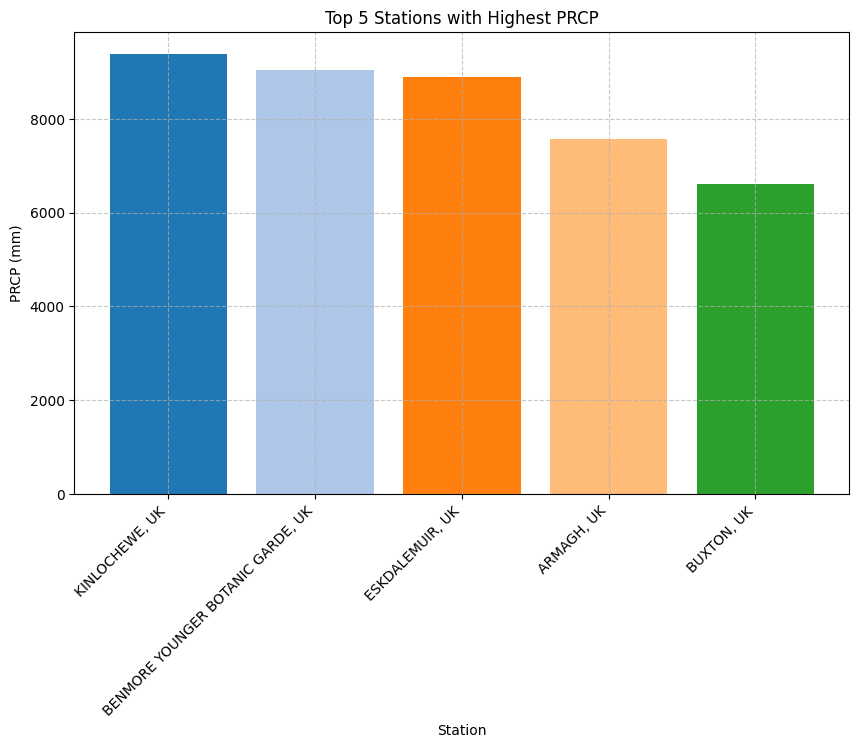


Top 5 Stations based on the highest total snow depth (SNWD):
    STATION            NAME      TMAX     TMIN        PRCP        SNWD
UK000003162 ESKDALEMUIR, UK 12.070805 4.306458 8900.543264 4001.225166
UKM00003091  CRAIBSTONE, UK 12.759394 5.724359 3955.451809 3789.281313
UK000070765        WICK, UK 11.328037 5.612473 3435.443264 3556.463000
UK000003005     LERWICK, UK 10.044634 5.732737 5450.874262 3078.893752
UKM00003017    KIRKWALL, UK 12.948180 6.077852 4820.701975 3078.610711


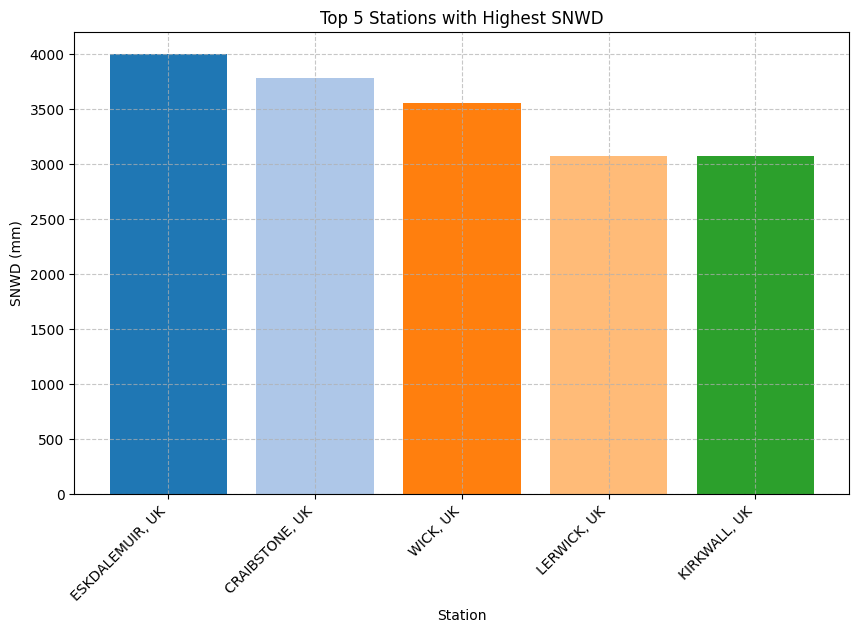


Top 5 Stations based on the lowest total precipitation (PRCP):
    STATION               NAME      TMAX     TMIN        PRCP        SNWD
UKE00105897  EAST BERGHOLT, UK 10.947093 4.526868  135.200000  104.441693
UKE00105887       PENICUIK, UK 13.591602 5.887690  400.783243  342.017852
UKE00105885       FASKALLY, UK 12.785641 5.286311 2180.200000  874.555716
UKW00035047    MANSTON, ENG UK 14.484304 7.659349 2335.607339 3005.053844
UKE00105003 CAMBRIDGE NIAB, UK 13.813249 6.551323 2597.900000 1759.440829


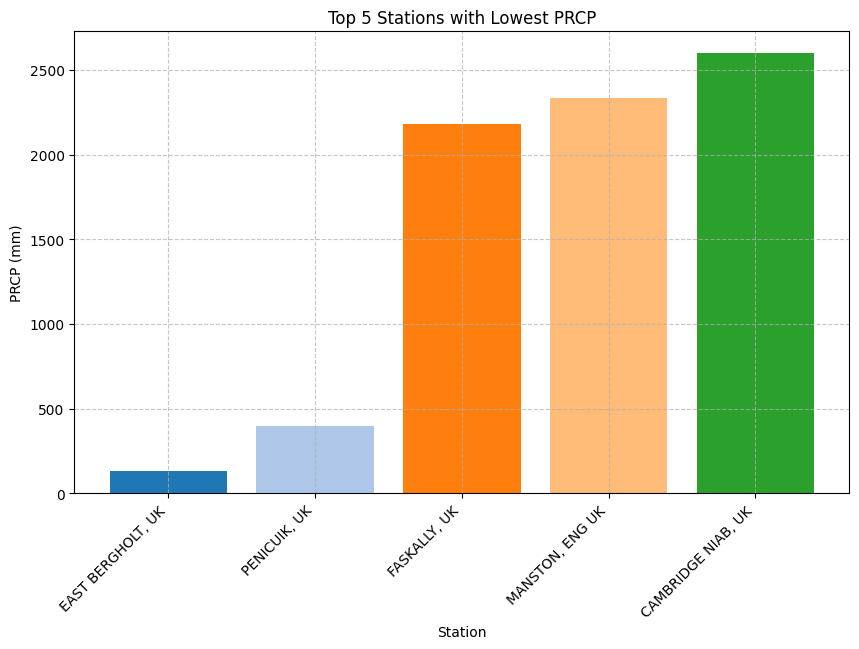


Top 5 Stations based on the lowest total snow depth (SNWD):
    STATION              NAME      TMAX     TMIN        PRCP       SNWD
UKE00105923          HURN, UK 15.719016 6.671778 4019.629792   0.000000
UKE00105897 EAST BERGHOLT, UK 10.947093 4.526868  135.200000 104.441693
UK000003808      CAMBORNE, UK 14.137688 8.977448 4965.195509 139.691333
UKE00105681    ALDERGROVE, UK 13.425653 6.761534 3781.495509 190.000000
UKM00003414      SHAWBURY, UK 14.513726 6.186656 3357.347755 296.078318


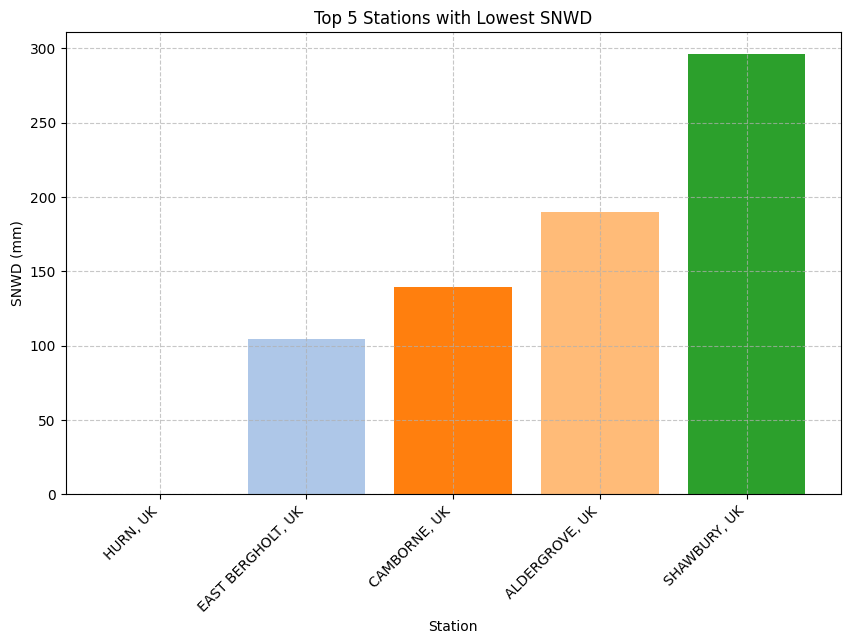

In [2]:
def aggregate_station_data(df):
    """
    Aggregates data by station, calculating the mean for temperature parameters (TMAX, TMIN)
    and the sum for precipitation and snow depth (PRCP, SNWD).
    
    Parameters:
        df (pd.DataFrame): The input DataFrame containing weather data.
    
    Returns:
        pd.DataFrame: A DataFrame with aggregated data by station.
    """
    return df.groupby(['STATION', 'NAME']).agg({
        'TMAX': 'mean',
        'TMIN': 'mean',
        'PRCP': 'sum',
        'SNWD': 'sum'
    }).reset_index()

def find_top_stations(df, column, n=5, largest=True):
    """
    Finds the top or lowest n stations based on a specified parameter.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with aggregated station data.
        column (str): The column name on which to base the ranking.
        n (int): The number of stations to return. Default is 5.
        largest (bool): Whether to return the largest values. Default is True.
    
    Returns:
        pd.DataFrame: A DataFrame containing the top or lowest n stations.
    """
    if largest:
        return df.nlargest(n, column)
    else:
        return df.nsmallest(n, column)

def plot_top_stations(df, column, title, xlabel, ylabel):
    """
    Plots the top or lowest n stations based on a specified parameter.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with top or lowest stations data.
        column (str): The column name to plot.
        title (str): The title of the plot.
        xlabel (str): The x-axis label.
        ylabel (str): The y-axis label.
    """
    plt.figure(figsize=(10, 6))
    plt.bar(df['NAME'], df[column], color=plt.cm.tab20.colors)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

def display_and_plot_top_stations(df):
    """
    Displays and plots the top and lowest 5 stations based on different weather parameters.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with aggregated station data.
    """
    top5_tmax = find_top_stations(df, 'TMAX', 5, largest=True)
    top5_tmin = find_top_stations(df, 'TMIN', 5, largest=True)
    top5_prcp = find_top_stations(df, 'PRCP', 5, largest=True)
    top5_snwd = find_top_stations(df, 'SNWD', 5, largest=True)
    lowest5_prcp = find_top_stations(df, 'PRCP', 5, largest=False)
    lowest5_snwd = find_top_stations(df, 'SNWD', 5, largest=False)
    
    print("Top 5 Stations based on the highest average maximum temperature (TMAX):")
    print(top5_tmax.to_string(index=False))
    plot_top_stations(top5_tmax, 'TMAX', 'Top 5 Stations with Highest TMAX', 'Station', 'TMAX (°C)')
    
    print("\nTop 5 Stations based on the highest average minimum temperature (TMIN):")
    print(top5_tmin.to_string(index=False))
    plot_top_stations(top5_tmin, 'TMIN', 'Top 5 Stations with Highest TMIN', 'Station', 'TMIN (°C)')
    
    print("\nTop 5 Stations based on the highest total precipitation (PRCP):")
    print(top5_prcp.to_string(index=False))
    plot_top_stations(top5_prcp, 'PRCP', 'Top 5 Stations with Highest PRCP', 'Station', 'PRCP (mm)')
    
    print("\nTop 5 Stations based on the highest total snow depth (SNWD):")
    print(top5_snwd.to_string(index=False))
    plot_top_stations(top5_snwd, 'SNWD', 'Top 5 Stations with Highest SNWD', 'Station', 'SNWD (mm)')
    
    print("\nTop 5 Stations based on the lowest total precipitation (PRCP):")
    print(lowest5_prcp.to_string(index=False))
    plot_top_stations(lowest5_prcp, 'PRCP', 'Top 5 Stations with Lowest PRCP', 'Station', 'PRCP (mm)')
    
    print("\nTop 5 Stations based on the lowest total snow depth (SNWD):")
    print(lowest5_snwd.to_string(index=False))
    plot_top_stations(lowest5_snwd, 'SNWD', 'Top 5 Stations with Lowest SNWD', 'Station', 'SNWD (mm)')

def main():
    """
    Main function to execute the station data aggregation and display the top and lowest stations.
    """
    station_aggregated_data = aggregate_station_data(daily_data)
    display_and_plot_top_stations(station_aggregated_data)

if __name__ == "__main__":
    main()


In [3]:
def display_summary_statistics(df, name, columns):
    """
    Displays summary statistics for the specified columns of a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        name (str): A name for the data to be displayed.
        columns (list): A list of columns for which to display summary statistics.
    """
    if df.empty:
        print(f"No data available for {name}.")
    else:
        print(f"\nSummary Statistics for {name}:\n")
        print(df[columns].describe())

def display_statistics_for_all_datasets(daily_data, monthly_data, yearly_data, columns):
    """
    Displays summary statistics for daily, monthly, and yearly datasets based on global definitions.

    Parameters:
        daily_data (pd.DataFrame): The daily dataset.
        monthly_data (pd.DataFrame): The monthly dataset.
        yearly_data (pd.DataFrame): The yearly dataset.
        columns (dict): A dictionary containing column definitions for each dataset.
    """
    display_summary_statistics(daily_data, 'Daily Data', columns['daily'])
    display_summary_statistics(monthly_data, 'Monthly Data', columns['monthly'])
    display_summary_statistics(yearly_data, 'Yearly Data', columns['yearly'])

def main():
    """
    Main function to execute the summary statistics display for all datasets.
    """
    display_statistics_for_all_datasets(daily_data, monthly_data, yearly_data, COLUMNS)

if __name__ == "__main__":
    main()



Summary Statistics for Daily Data:

                TMAX           TAVG           TMIN           PRCP  \
count  134936.000000  134936.000000  134936.000000  134936.000000   
mean       13.813249       9.942567       6.551323       2.747755   
std         5.390773       2.384579       4.729702       5.277994   
min        -9.300000      -8.100000     -23.000000       0.000000   
25%        10.200000       9.942567       3.600000       0.000000   
50%        13.813249       9.942567       6.551323       0.600000   
75%        17.100000       9.942567       9.700000       2.747755   
max        40.200000      29.800000      24.500000     140.000000   

                SNWD  
count  134936.000000  
mean        1.147711  
std         3.630856  
min         0.000000  
25%         1.147711  
50%         1.147711  
75%         1.147711  
max       279.000000  

Summary Statistics for Monthly Data:

              EMXP         EMXT        DSND         PRCP         DX90  \
count  4243.000000  42

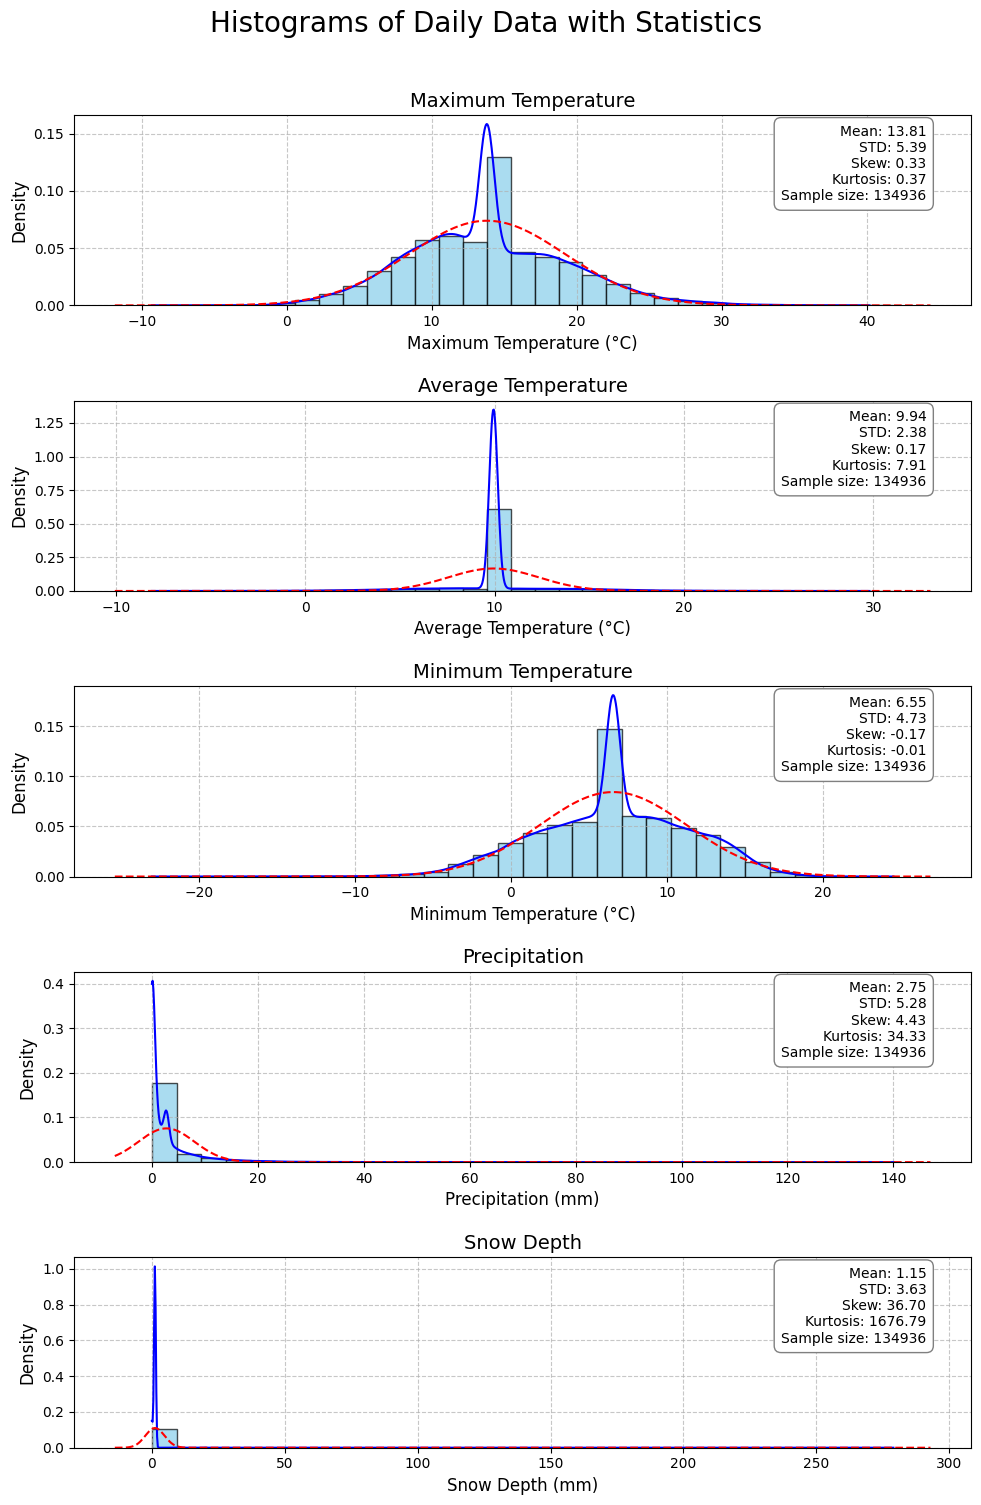

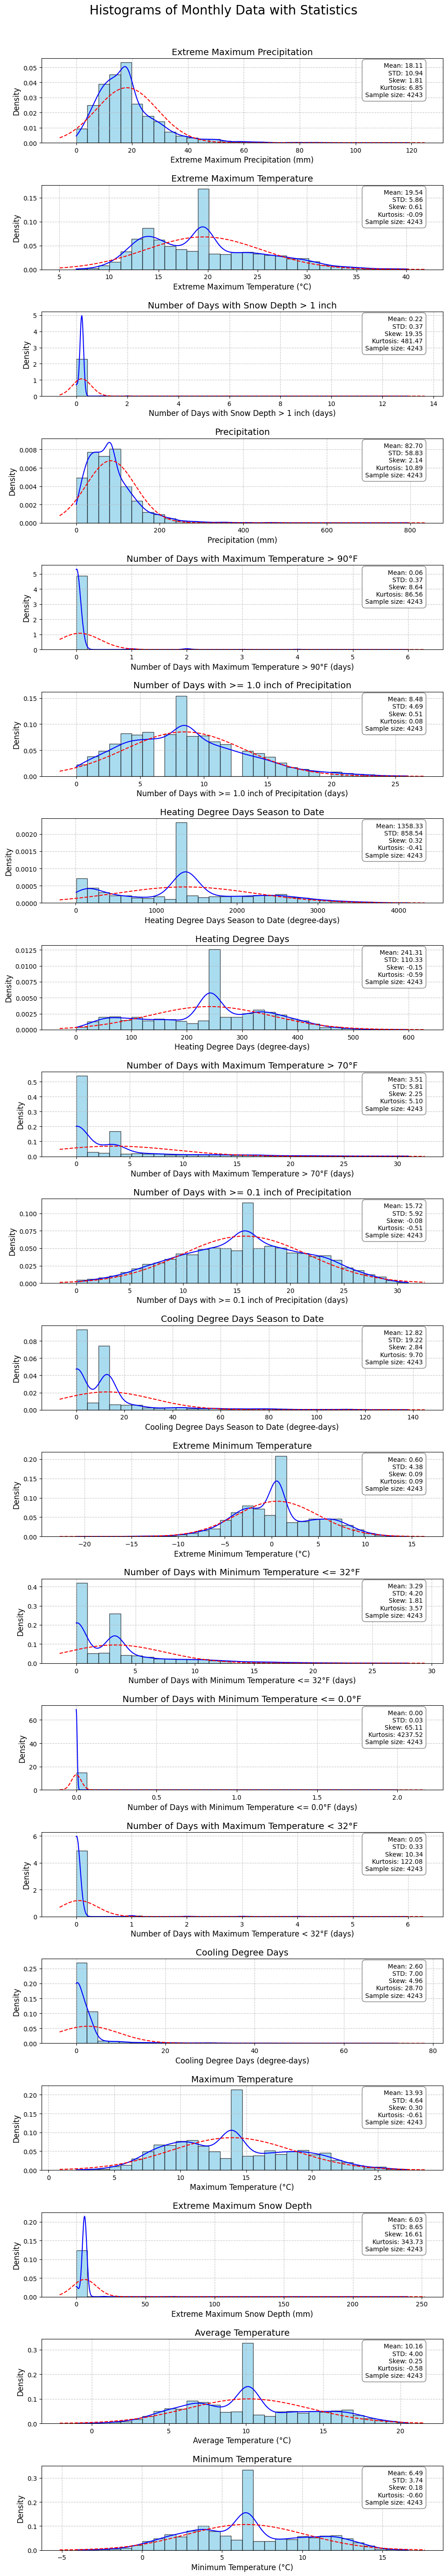

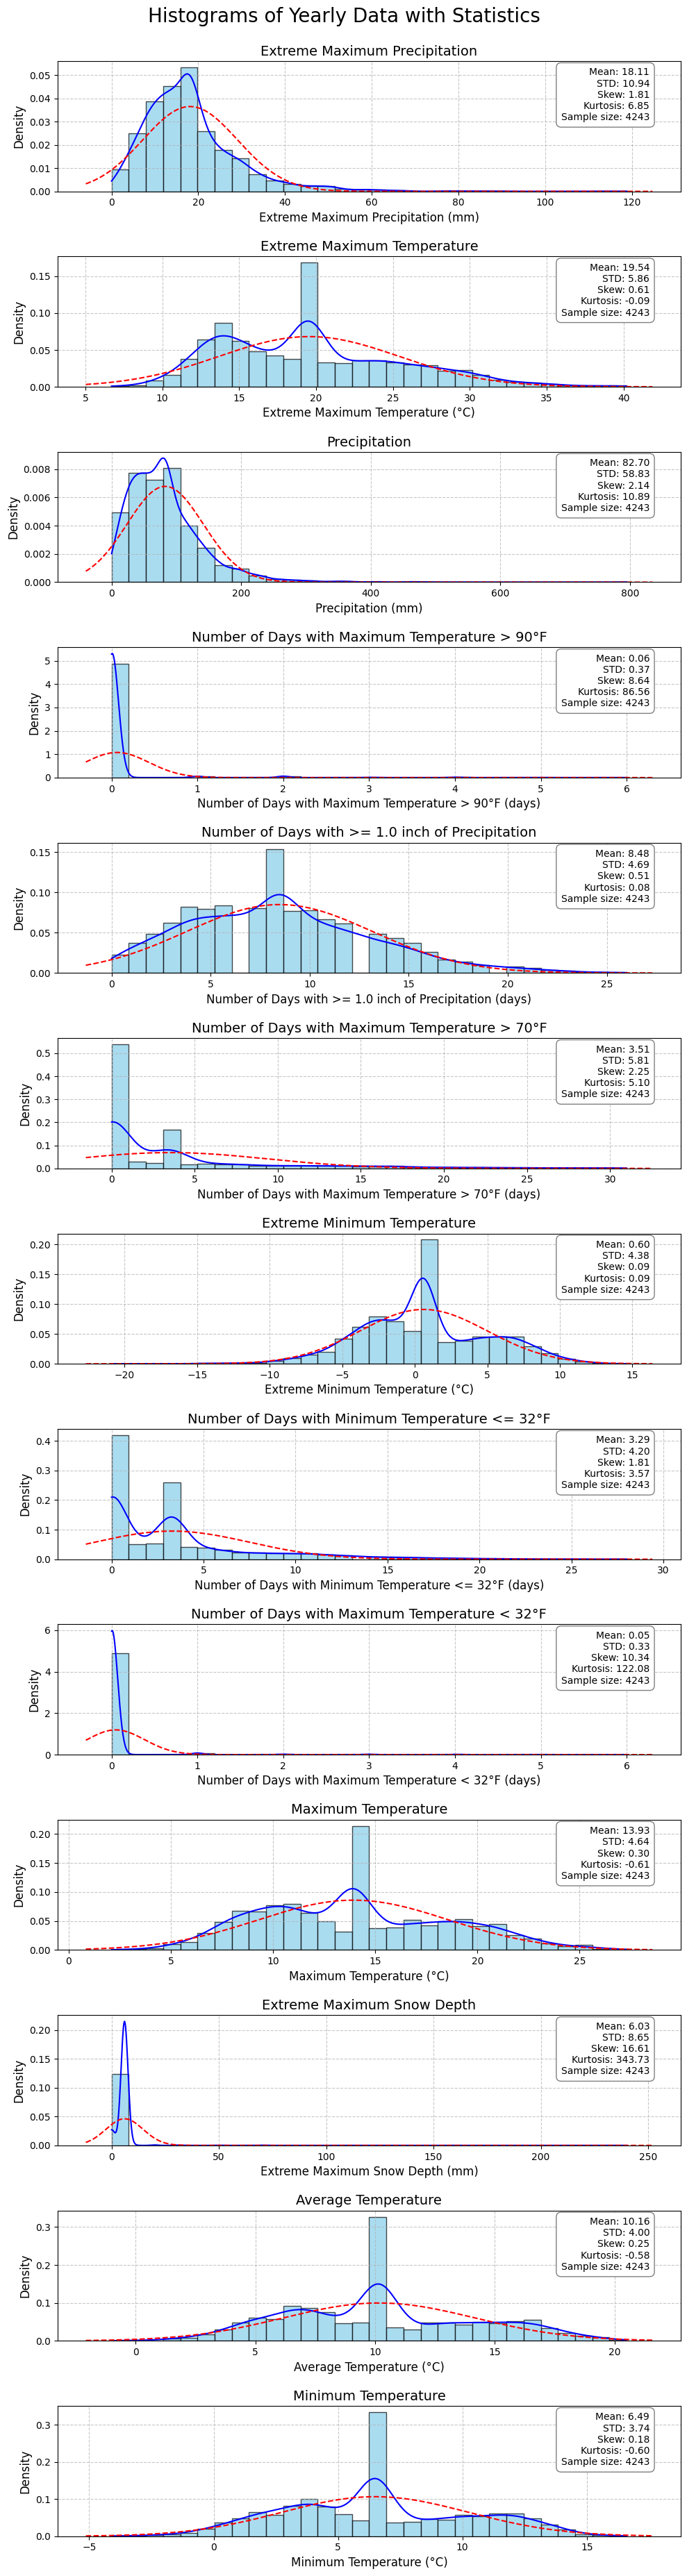

In [4]:
def plot_histogram_and_kde(ax, data, col_name, bin_width):
    """
    Plots the histogram and KDE for a specific column of data.
    
    Parameters:
        ax (matplotlib.axes.Axes): The axes object to plot on.
        data (pd.Series): The data to plot.
        col_name (str): The name of the column being plotted.
        bin_width (float): The width of the bins for the histogram.
    """
    bins = np.arange(data.min(), data.max() + bin_width, bin_width)
    ax.hist(data, bins=bins, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    
    if len(data.unique()) > 1:
        kde = gaussian_kde(data)
        x = np.linspace(data.min(), data.max(), 1000)
        ax.plot(x, kde(x), color='blue')

    mean = data.mean()
    std_dev = data.std()
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 1000)
    p = norm.pdf(x, mean, std_dev)
    ax.plot(x, p, color='red', linestyle='dashed')

def add_statistics_text(ax, data, col_name):
    """
    Adds statistical annotations to the plot.
    
    Parameters:
        ax (matplotlib.axes.Axes): The axes object to add text to.
        data (pd.Series): The data to calculate statistics for.
        col_name (str): The name of the column being analyzed.
    """
    mean = data.mean()
    std_dev = data.std()
    skewness = skew(data)
    kurt = kurtosis(data)
    sample_size = len(data)
    
    stats_text = (f'Mean: {mean:.2f}\n'
                  f'STD: {std_dev:.2f}\n'
                  f'Skew: {skewness:.2f}\n'
                  f'Kurtosis: {kurt:.2f}\n'
                  f'Sample size: {sample_size}')
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            fontsize=10, bbox=dict(boxstyle='round,pad=0.5', edgecolor='gray', facecolor='white'))

def plot_histograms_with_stats(df, name, cols, col_names, units, figsize, suptitle_y):
    """
    Plots histograms with statistics for a given dataset.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        name (str): The name of the dataset (e.g., 'Daily', 'Monthly', 'Yearly').
        cols (list): List of column names to plot.
        col_names (list): List of column display names for the plots.
        units (list): List of units for each column.
        figsize (tuple): Figure size for the plot.
        suptitle_y (float): Y position for the subplot title.
    """
    num_rows = len(cols)
    fig, axes = plt.subplots(num_rows, 1, figsize=figsize, sharex=False)
    fig.suptitle(f'Histograms of {name} Data with Statistics', fontsize=20, y=suptitle_y)
    
    for i, (col, col_name, unit) in enumerate(zip(cols, col_names, units)):
        data = pd.to_numeric(df[col], errors='coerce').dropna()
        ax = axes[i] if num_rows > 1 else axes
        
        if not data.empty:
            bin_width = (data.max() - data.min()) / 30
            plot_histogram_and_kde(ax, data, col_name, bin_width)
            add_statistics_text(ax, data, col_name)
            
            ax.set_title(col_name, fontsize=14)
            ax.set_ylabel('Density', fontsize=12)
            ax.set_xlabel(f'{col_name} ({unit})', fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.7)
        else:
            ax.set_title(f"{col_name} - No Data Available")
            ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.subplots_adjust(top=0.93, hspace=0.5)
    plt.show()

def plot_histograms_for_dataset(daily_data, monthly_data, yearly_data, columns, column_names, units):
    """
    Plots histograms with statistics for daily, monthly, and yearly datasets.
    
    Parameters:
        daily_data (pd.DataFrame): The daily dataset.
        monthly_data (pd.DataFrame): The monthly dataset.
        yearly_data (pd.DataFrame): The yearly dataset.
        columns (dict): Dictionary of columns for each dataset.
        column_names (dict): Dictionary of column display names for each dataset.
        units (dict): Dictionary of units for each dataset.
    """
    daily_figsize = (10, len(columns['daily']) * 3)
    plot_histograms_with_stats(daily_data, 'Daily', columns['daily'], column_names['daily'], units['daily'], daily_figsize, suptitle_y=1)

    monthly_figsize = (10, len(columns['monthly']) * 3)
    plot_histograms_with_stats(monthly_data, 'Monthly', columns['monthly'], column_names['monthly'], units['monthly'], monthly_figsize, suptitle_y=0.95)

    yearly_figsize = (10, len(columns['yearly']) * 3)
    plot_histograms_with_stats(yearly_data, 'Yearly', columns['yearly'], column_names['yearly'], units['yearly'], yearly_figsize, suptitle_y=0.95)

def main():
    """
    Main function to execute histogram plotting for all datasets.
    """
    plot_histograms_for_dataset(daily_data, monthly_data, yearly_data, COLUMNS, COLUMN_NAMES, UNITS)

if __name__ == "__main__":
    main()


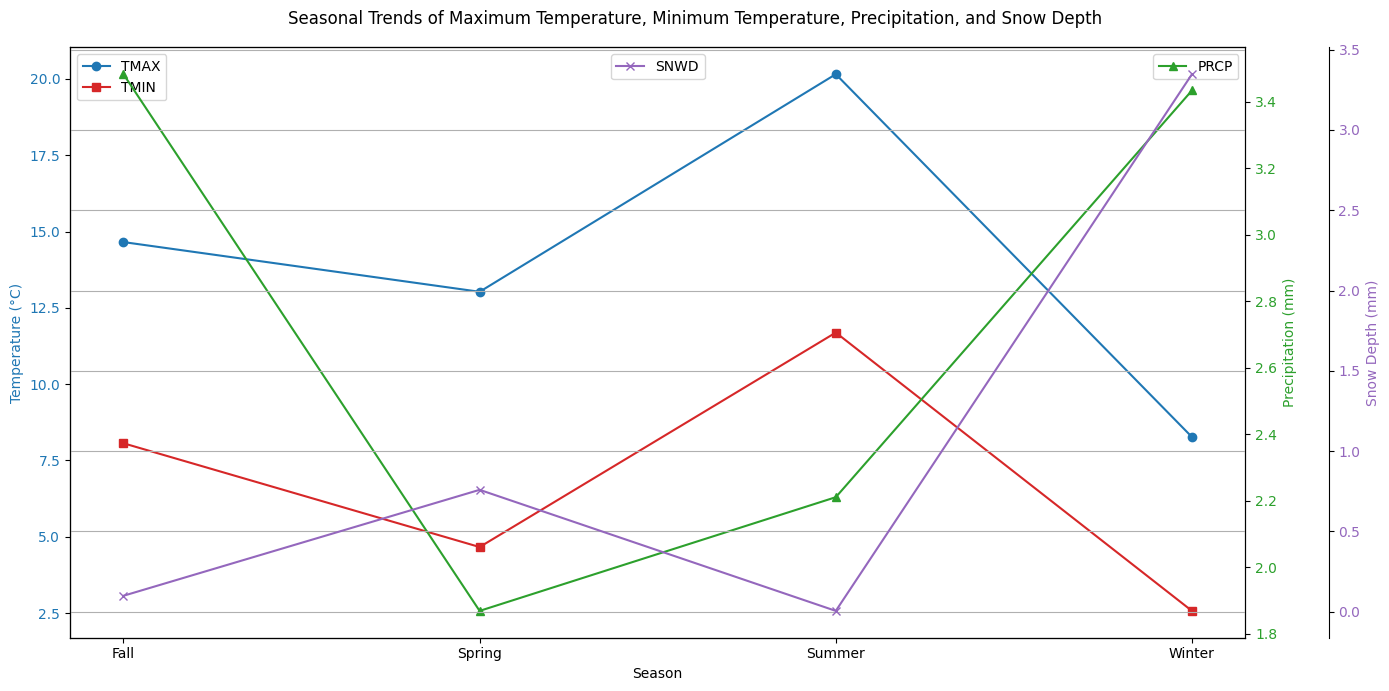

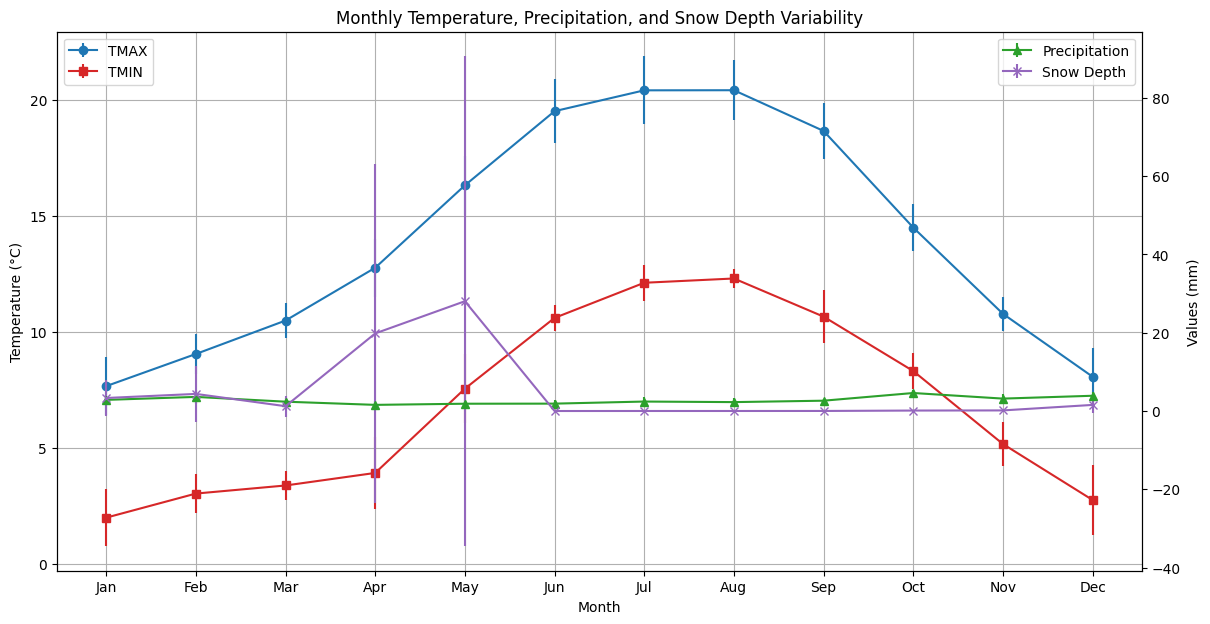

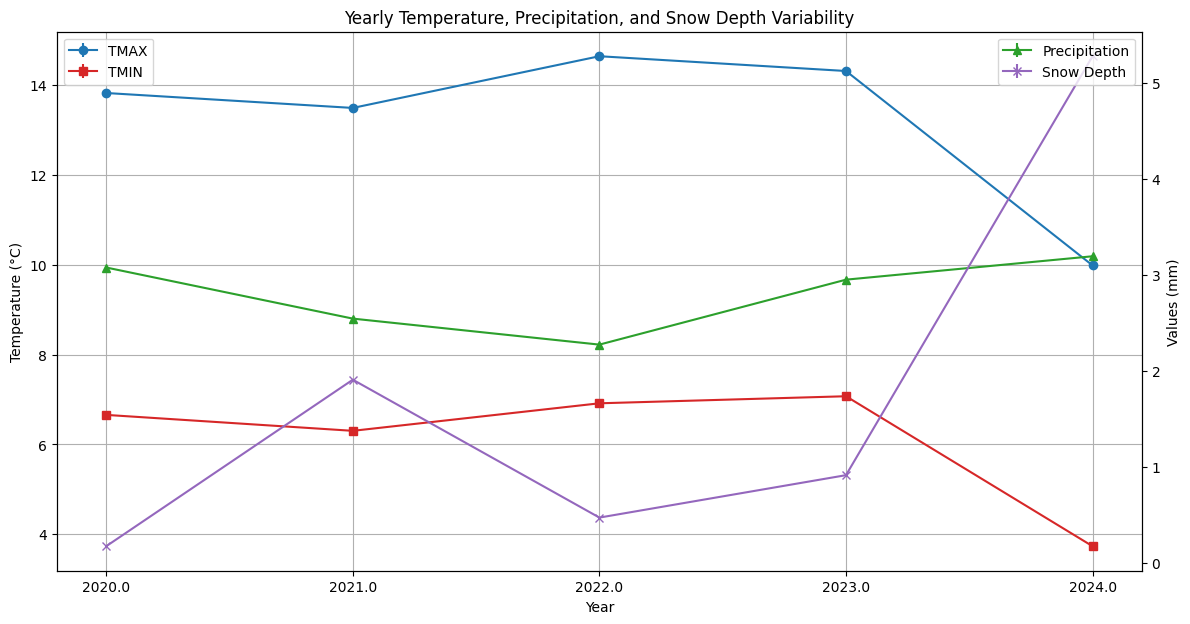

In [5]:
def categorize_season(date):
    """
    Categorizes a given date into a season (Winter, Spring, Summer, Fall).
    """
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

def plot_seasonal_trends(df, title):
    """
    Plots seasonal trends for temperature, precipitation, and snow depth.
    """
    fig, ax1 = plt.subplots(figsize=(14, 7))
    color1, color2, color3, color4 = 'tab:blue', 'tab:green', 'tab:red', 'tab:purple'

    ax1.set_xlabel('Season')
    ax1.set_ylabel('Temperature (°C)', color=color1)
    ax1.plot(df.index, df['TMAX'], color=color1, label='TMAX', marker='o')
    ax1.plot(df.index, df['TMIN'], color=color3, label='TMIN', marker='s')
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Precipitation (mm)', color=color2)
    ax2.plot(df.index, df['PRCP'], color=color2, label='PRCP', marker='^')
    ax2.tick_params(axis='y', labelcolor=color2)

    if 'SNWD' in df.columns:
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 60))
        ax3.set_ylabel('Snow Depth (mm)', color=color4)
        ax3.plot(df.index, df['SNWD'], color=color4, label='SNWD', marker='x')
        ax3.tick_params(axis='y', labelcolor=color4)
        ax3.legend(loc='upper center')

    fig.suptitle(title)
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.show()

def calculate_monthly_stats(df, columns):
    """
    Resamples data to monthly frequency and calculates mean and standard deviation for each parameter.
    """
    monthly_data = df[columns].resample('M').mean()
    monthly_data['Month'] = monthly_data.index.month
    monthly_stats = monthly_data.groupby('Month').agg({col: ['mean', 'std'] for col in columns})
    monthly_stats.columns = [f'{col}_{stat}' for col, stat in monthly_stats.columns]
    return monthly_stats

def plot_combined_monthly_variability(stats, title):
    """
    Plots monthly variability with error bars for temperature, precipitation, and snow depth.
    """
    fig, ax1 = plt.subplots(figsize=(14, 7))
    months = range(1, 13)

    ax1.errorbar(months, stats['TMAX_mean'], yerr=stats['TMAX_std'], fmt='-o', color='tab:blue', label='TMAX')
    ax1.errorbar(months, stats['TMIN_mean'], yerr=stats['TMIN_std'], fmt='-s', color='tab:red', label='TMIN')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.errorbar(months, stats['PRCP_mean'], yerr=stats['PRCP_std'], fmt='-^', color='tab:green', label='Precipitation')
    ax2.errorbar(months, stats['SNWD_mean'], yerr=stats['SNWD_std'], fmt='-x', color='tab:purple', label='Snow Depth')
    ax2.set_ylabel('Values (mm)')
    ax2.legend(loc='upper right')

    plt.xticks(months, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.title(title)
    plt.show()

def calculate_yearly_stats(df, columns):
    """
    Resamples data to yearly frequency and calculates mean and standard deviation for each parameter.
    """
    yearly_data = df[columns].resample('Y').mean()
    yearly_data['Year'] = yearly_data.index.year
    yearly_stats = yearly_data.groupby('Year').agg(['mean', 'std'])
    yearly_stats.columns = ['_'.join(col) for col in yearly_stats.columns]
    return yearly_stats

def plot_yearly_variability(stats, title):
    """
    Plots yearly variability with error bars for temperature, precipitation, and snow depth.
    """
    fig, ax1 = plt.subplots(figsize=(14, 7))
    years = stats.index
    custom_ticks = [f"{year}.0" for year in years]

    ax1.errorbar(custom_ticks, stats['TMAX_mean'], yerr=stats['TMAX_std'], fmt='-o', color='tab:blue', label='TMAX')
    ax1.errorbar(custom_ticks, stats['TMIN_mean'], yerr=stats['TMIN_std'], fmt='-s', color='tab:red', label='TMIN')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.errorbar(custom_ticks, stats['PRCP_mean'], yerr=stats['PRCP_std'], fmt='-^', color='tab:green', label='Precipitation')
    ax2.errorbar(custom_ticks, stats['SNWD_mean'], yerr=stats['SNWD_std'], fmt='-x', color='tab:purple', label='Snow Depth')
    ax2.set_ylabel('Values (mm)')
    ax2.legend(loc='upper right')

    plt.title(title)
    plt.xticks(range(0, len(custom_ticks)), custom_ticks, rotation=45)
    plt.show()

def load_and_prepare_data(filepath):
    """
    Loads weather data from a CSV file and categorizes the season for each date.
    """
    df = pd.read_csv(filepath, parse_dates=['DATE'], index_col='DATE')
    df = df.sort_index()
    df['Season'] = df.index.map(categorize_season)
    return df

def main():
    """
    Main function to load data, calculate statistics, and plot trends and variability.
    """
    # Load the data
    daily_data = load_and_prepare_data('Daily Summaries - GHCND.csv')

    # Aggregate data by season
    daily_data_numeric = daily_data.select_dtypes(include=[np.number])
    daily_data_numeric['Season'] = daily_data['Season']
    seasonal_data = daily_data_numeric.groupby('Season').mean()

    # Plot seasonal trends
    plot_seasonal_trends(seasonal_data, 'Seasonal Trends of Maximum Temperature, Minimum Temperature, Precipitation, and Snow Depth')

    # Columns to analyze
    columns = ['TMAX', 'TMIN', 'PRCP', 'SNWD']

    # Calculate and plot monthly statistics
    monthly_stats = calculate_monthly_stats(daily_data, columns)
    plot_combined_monthly_variability(monthly_stats, 'Monthly Temperature, Precipitation, and Snow Depth Variability')

    # Calculate and plot yearly statistics
    yearly_stats = calculate_yearly_stats(daily_data, columns)
    plot_yearly_variability(yearly_stats, 'Yearly Temperature, Precipitation, and Snow Depth Variability')

if __name__ == "__main__":
    main()


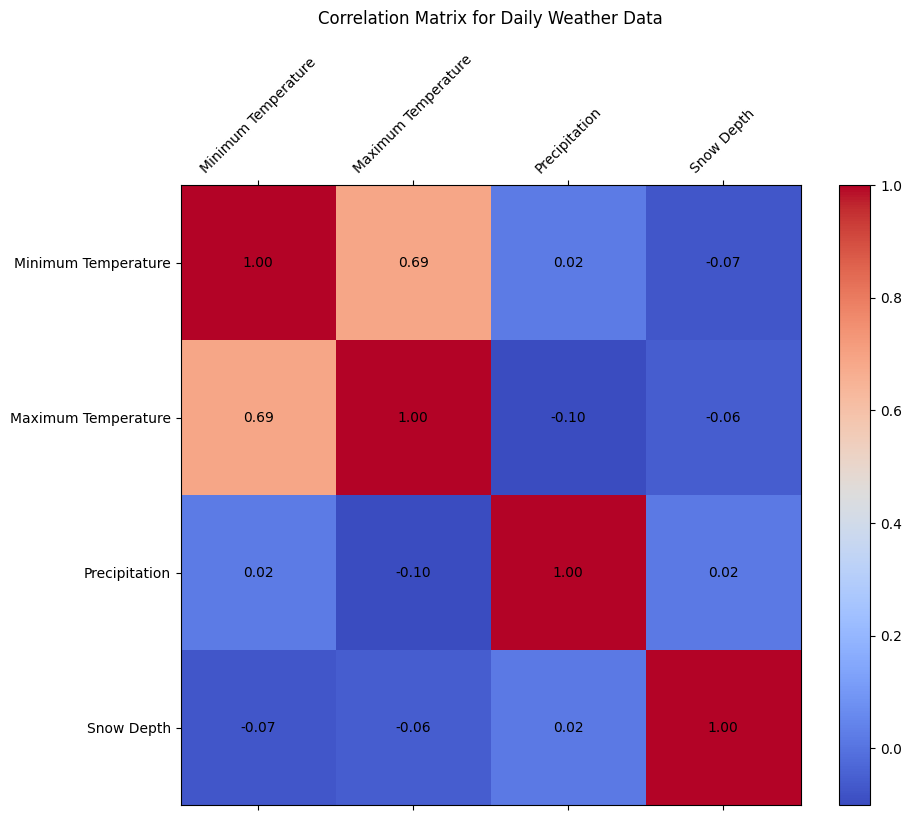

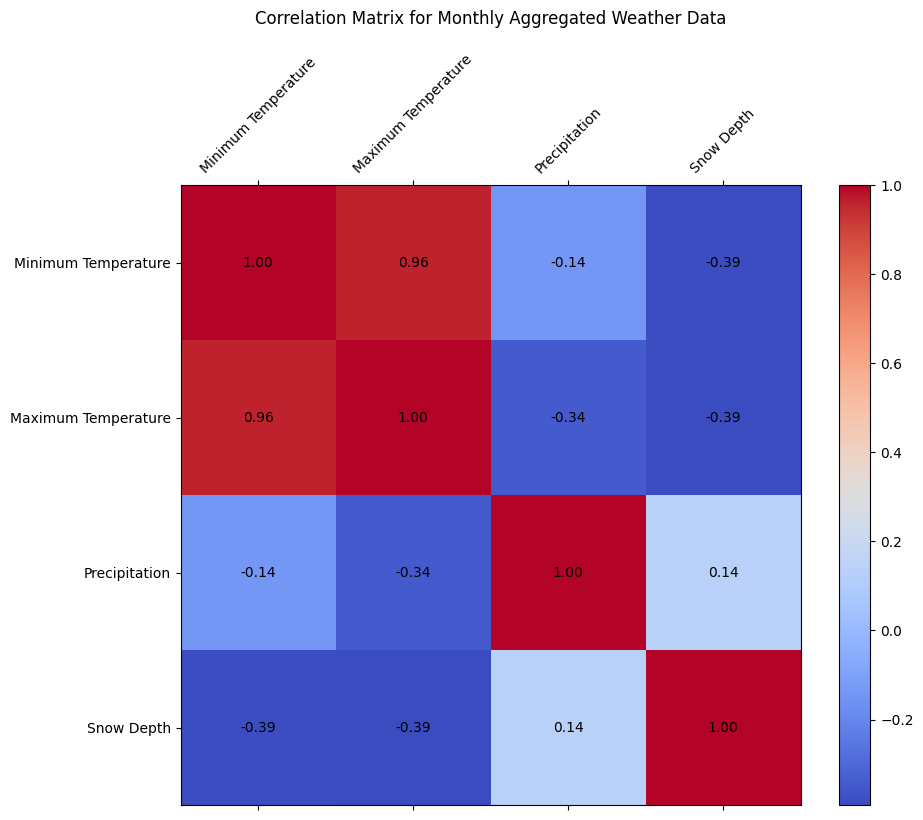

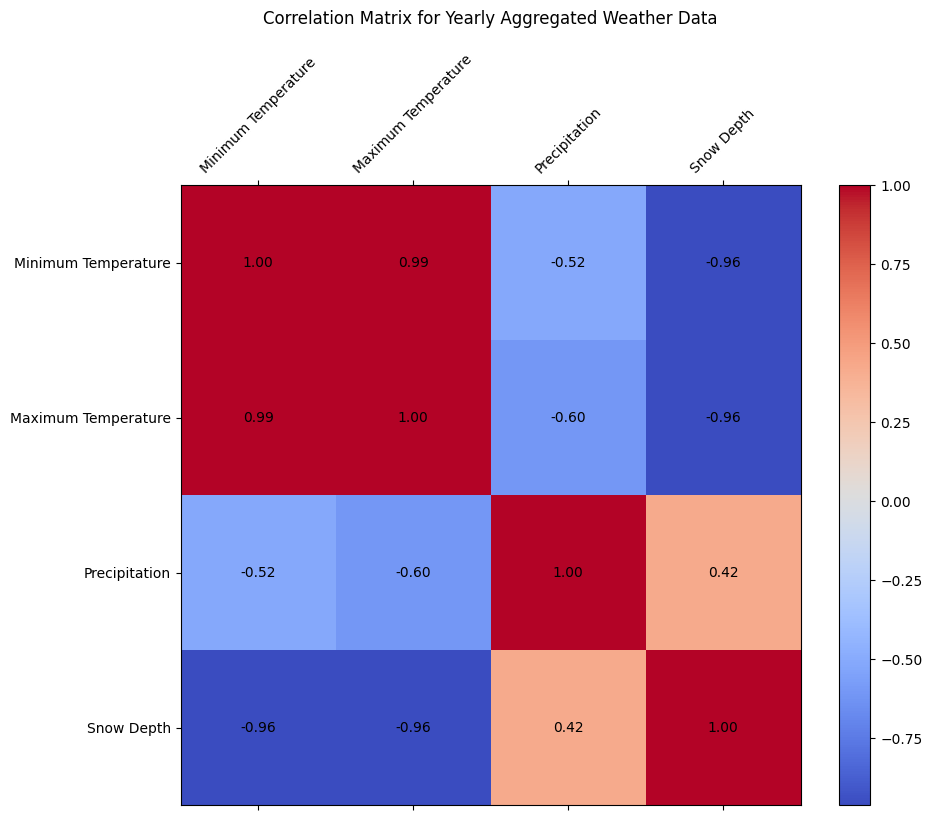

In [6]:
def select_and_dropna(df, columns):
    """
    Selects specific columns from a DataFrame and drops rows with NaN values.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): The list of columns to select.
        
    Returns:
        pd.DataFrame: A DataFrame with the selected columns and NaN values dropped.
    """
    return df[columns].dropna()

def aggregate_data(df, frequency):
    """
    Aggregates data by the specified frequency (e.g., monthly or yearly).
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        frequency (str): The frequency for resampling (e.g., 'M' for monthly, 'Y' for yearly).
        
    Returns:
        pd.DataFrame: A DataFrame with aggregated data by the specified frequency.
    """
    return df.resample(frequency).mean()

def plot_correlation_matrix(data, title, column_names):
    """
    Plots the correlation matrix with correlation values displayed.
    
    Parameters:
        data (pd.DataFrame): The input DataFrame.
        title (str): The title for the plot.
        column_names (list): The list of column names to display in the plot.
    """
    correlation_matrix = data.corr()

    plt.figure(figsize=(10, 8))
    plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
    plt.colorbar()

    # Display correlation values in the matrix
    for (i, j), val in np.ndenumerate(correlation_matrix.values):
        plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

    # Add labels with column names
    plt.xticks(range(len(column_names)), column_names, rotation=45)
    plt.yticks(range(len(column_names)), column_names)
    plt.title(title, pad=20)
    plt.show()

def main():
    """
    Main function to perform data selection, aggregation, and correlation matrix plotting.
    """
    # Assuming daily_data is already loaded and preprocessed
    selected_columns = ['TMIN', 'TMAX', 'PRCP', 'SNWD']
    column_names = ['Minimum Temperature', 'Maximum Temperature', 'Precipitation', 'Snow Depth']

    # Select specific columns and drop NaN values
    filtered_data = select_and_dropna(daily_data, selected_columns)

    # Aggregate data by month and year
    monthly_aggregated_data = aggregate_data(filtered_data, 'M')
    yearly_aggregated_data = aggregate_data(filtered_data, 'Y')

    # Plot correlation matrix for daily, monthly, and yearly data
    plot_correlation_matrix(filtered_data, 'Correlation Matrix for Daily Weather Data', column_names)
    plot_correlation_matrix(monthly_aggregated_data, 'Correlation Matrix for Monthly Aggregated Weather Data', column_names)
    plot_correlation_matrix(yearly_aggregated_data, 'Correlation Matrix for Yearly Aggregated Weather Data', column_names)

if __name__ == "__main__":
    main()


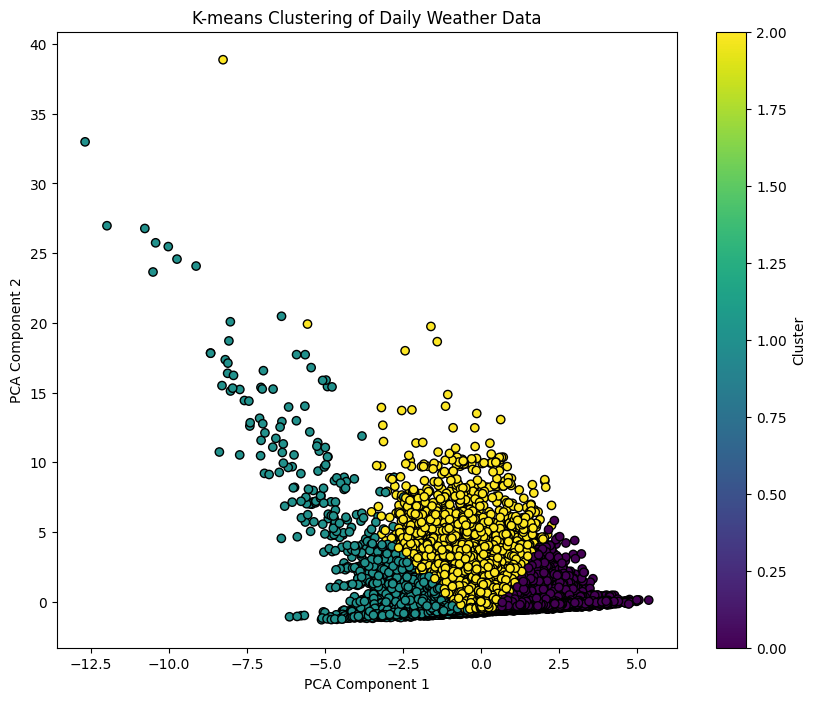

In [7]:
def prepare_data(df, columns):
    """
    Prepares the data by selecting specific columns and scaling the values.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): The list of columns to select.
        
    Returns:
        np.ndarray: Scaled data array.
    """
    X = df[columns].dropna()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

def apply_pca(data, n_components=2):
    """
    Applies PCA transformation to reduce the dimensionality of the data.
    
    Parameters:
        data (np.ndarray): The input scaled data.
        n_components (int): The number of principal components to keep.
        
    Returns:
        np.ndarray: Transformed data with reduced dimensions.
    """
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(data)
    return X_pca

def apply_kmeans(data, n_clusters=3, random_state=42):
    """
    Applies K-means clustering to the data.
    
    Parameters:
        data (np.ndarray): The input scaled data.
        n_clusters (int): The number of clusters for K-means.
        random_state (int): The random state for reproducibility.
        
    Returns:
        np.ndarray: Cluster labels for each data point.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(data)
    return clusters

def plot_clusters(X_pca, clusters, title):
    """
    Plots the clusters on a 2D PCA-transformed space.
    
    Parameters:
        X_pca (np.ndarray): PCA-transformed data.
        clusters (np.ndarray): Cluster labels for each data point.
        title (str): The title of the plot.
    """
    plt.figure(figsize=(10, 8))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

def main():
    """
    Main function to execute the data preparation, PCA, K-means clustering, and plotting.
    """
    columns = ['TMAX', 'TMIN', 'PRCP', 'SNWD']
    
    # Prepare the data
    X_scaled = prepare_data(daily_data, columns)
    
    # Apply PCA
    X_pca = apply_pca(X_scaled)
    
    # Apply K-means clustering
    clusters = apply_kmeans(X_scaled)
    
    # Plot the clusters
    plot_clusters(X_pca, clusters, 'K-means Clustering of Daily Weather Data')

if __name__ == "__main__":
    main()


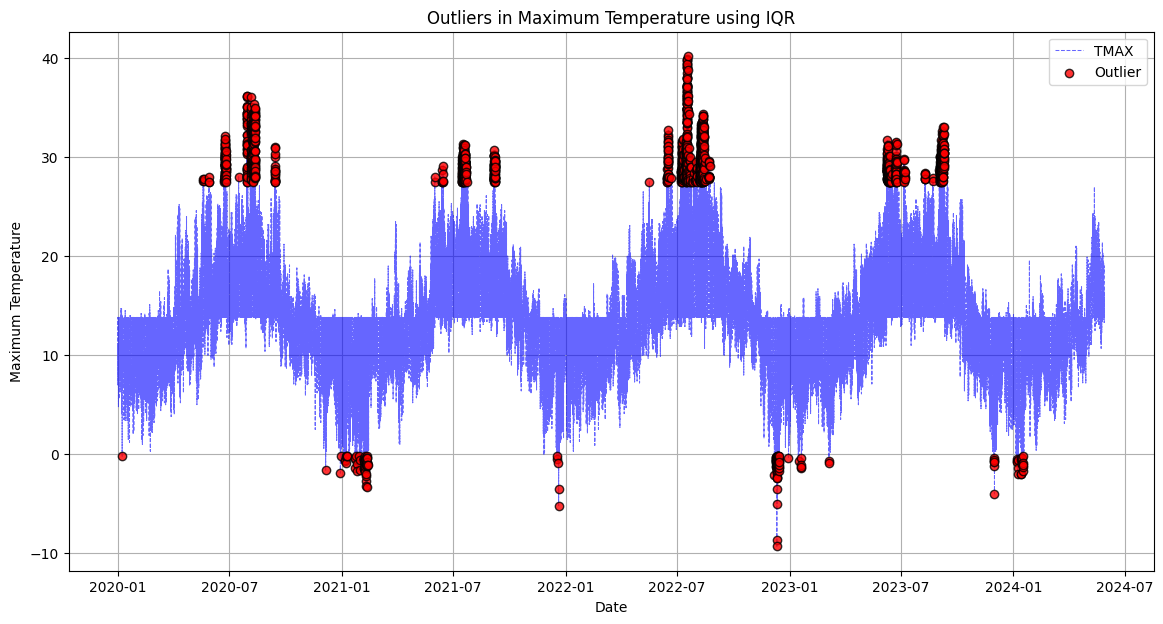

Column: TMAX
Number of Outliers: 1819
Mean of Outliers: 26.65
Standard Deviation of Outliers: 9.75
Minimum Outlier Value: -9.30
Maximum Outlier Value: 40.20




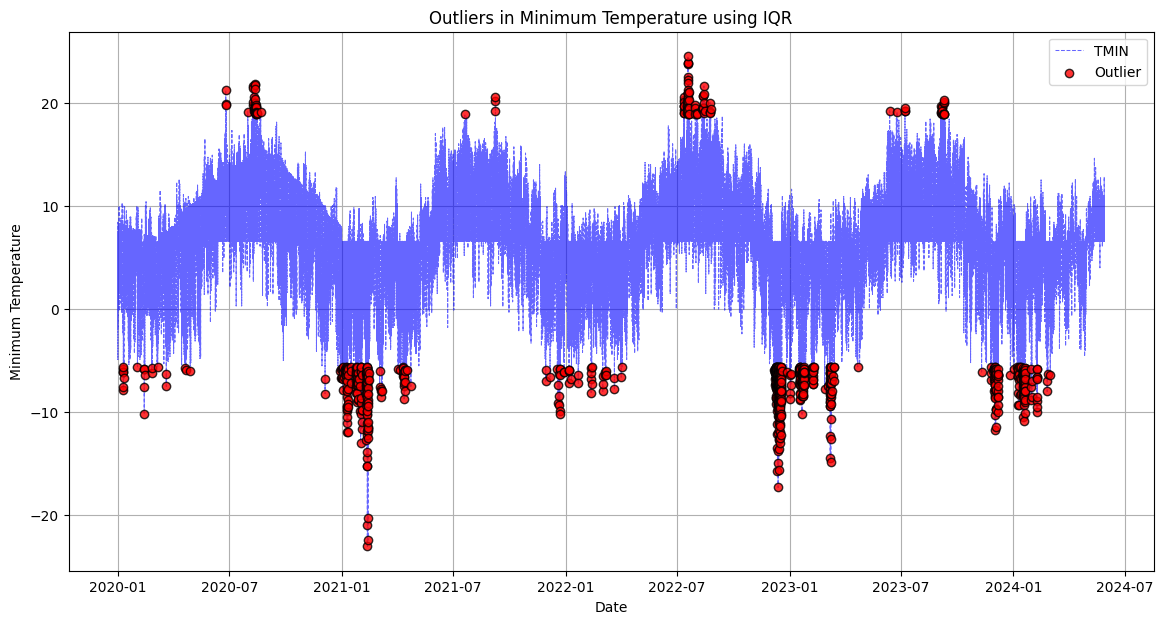

Column: TMIN
Number of Outliers: 991
Mean of Outliers: -3.97
Standard Deviation of Outliers: 9.32
Minimum Outlier Value: -23.00
Maximum Outlier Value: 24.50




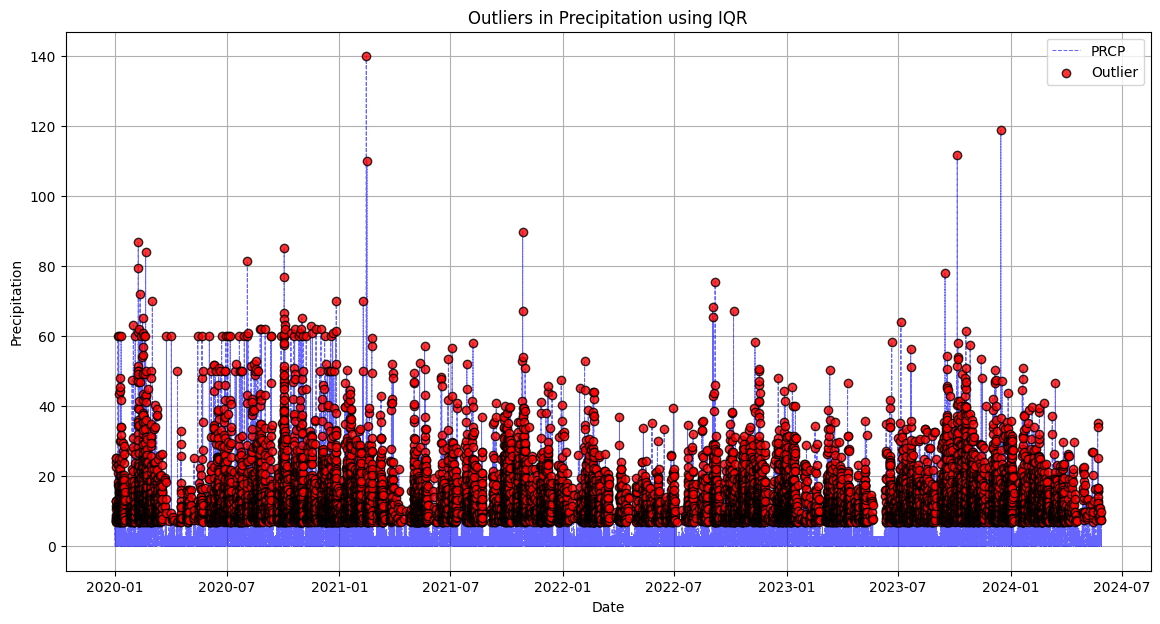

Column: PRCP
Number of Outliers: 16066
Mean of Outliers: 14.01
Standard Deviation of Outliers: 8.34
Minimum Outlier Value: 6.90
Maximum Outlier Value: 140.00




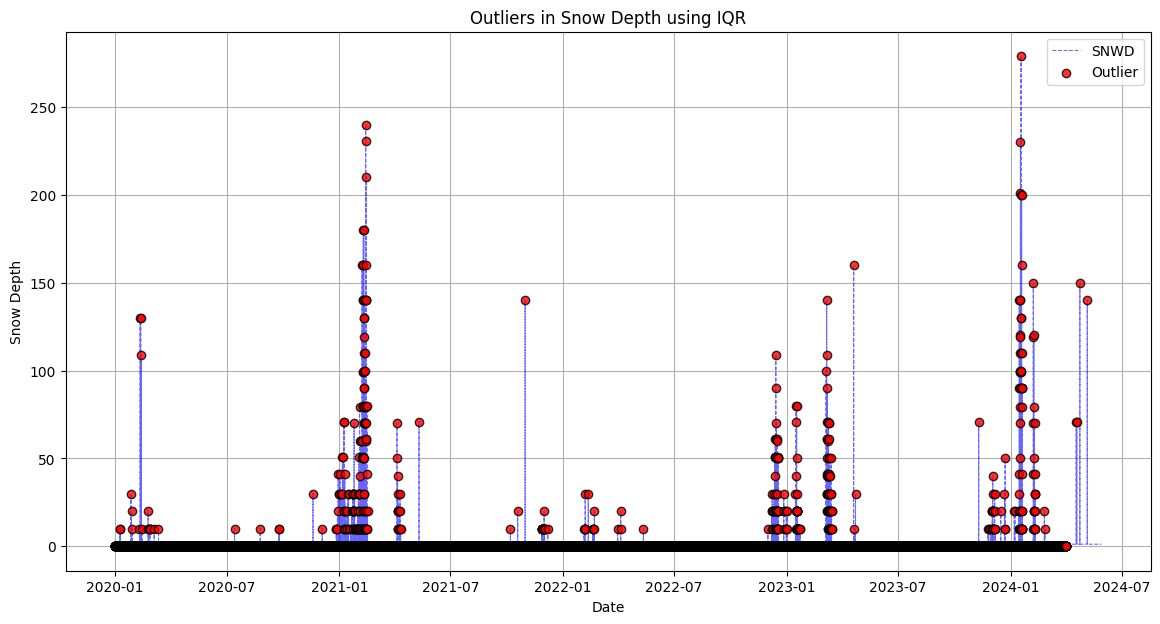

Column: SNWD
Number of Outliers: 17365
Mean of Outliers: 1.15
Standard Deviation of Outliers: 10.12
Minimum Outlier Value: 0.00
Maximum Outlier Value: 279.00




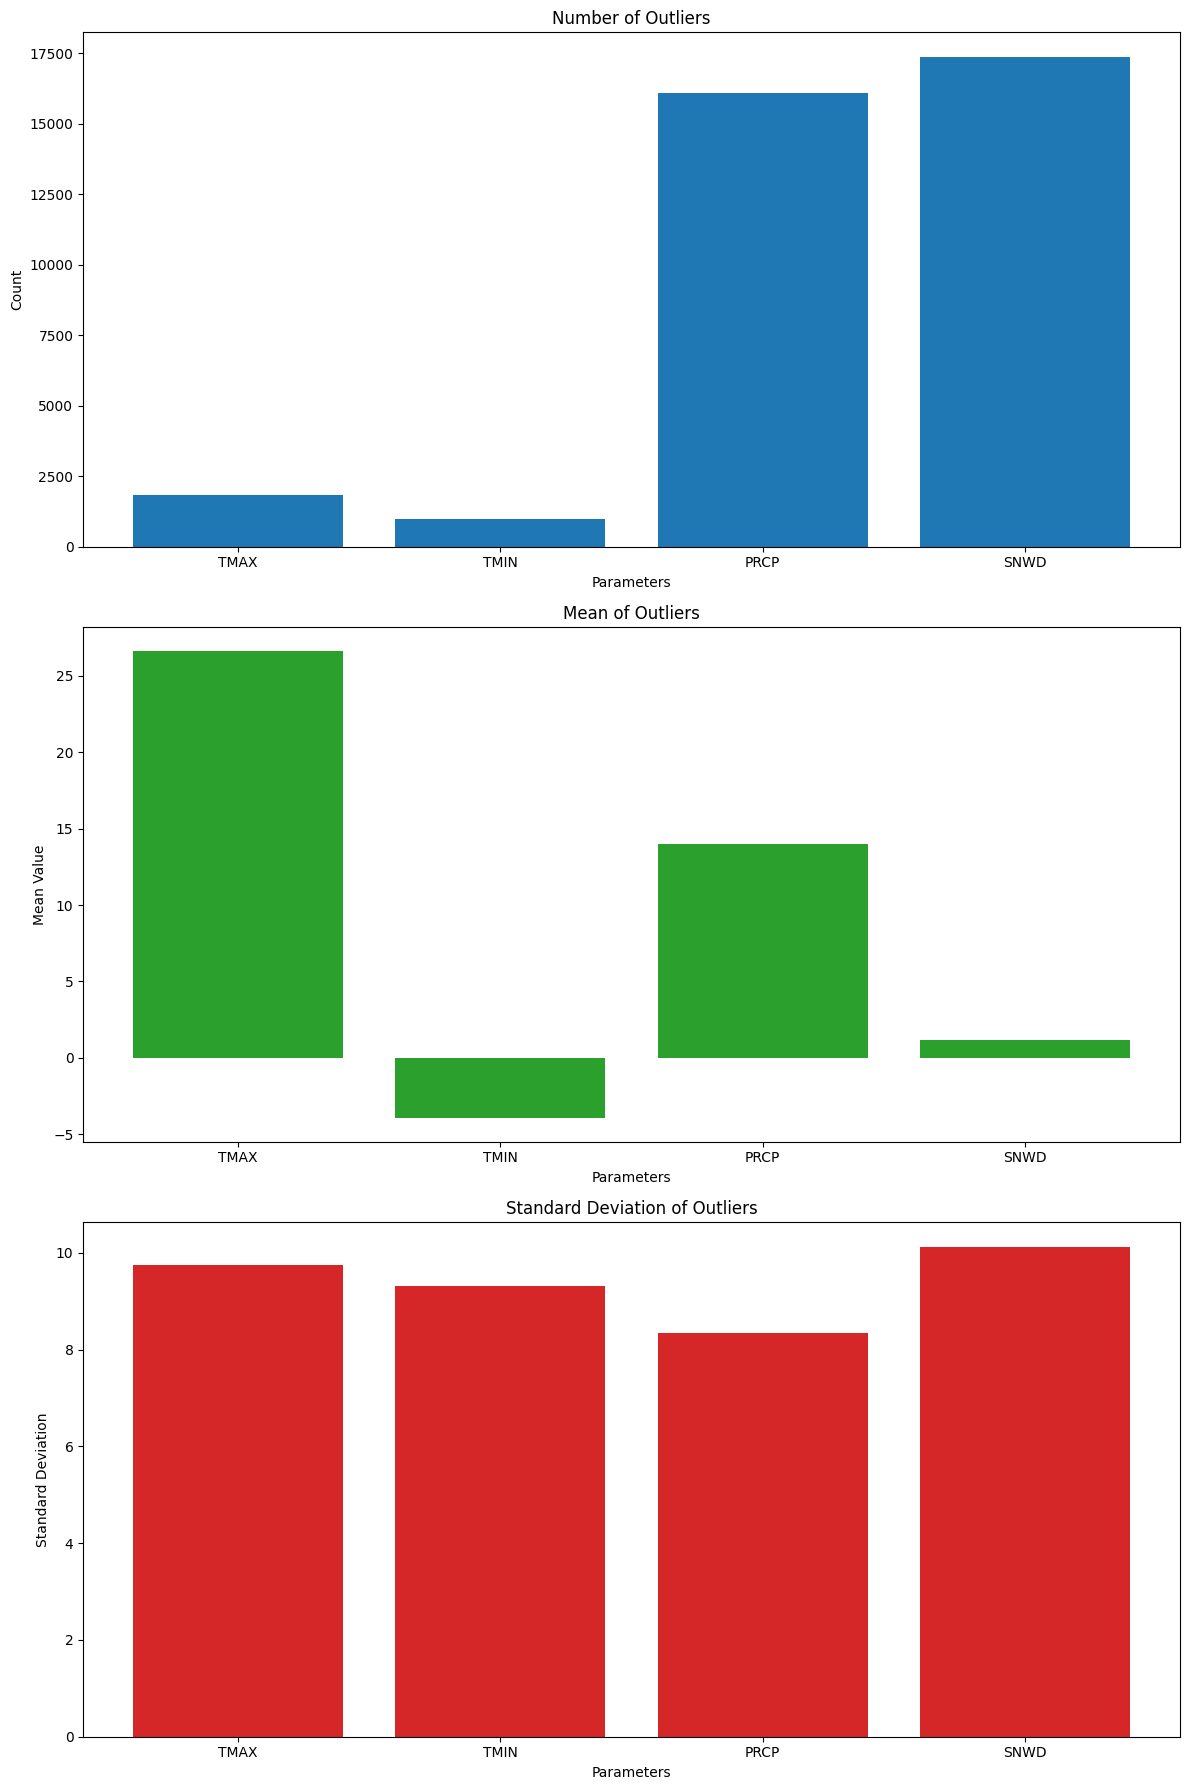

In [8]:
def detect_outliers_iqr(df, column):
    """
    Detects outliers in a DataFrame column using the Interquartile Range (IQR) method.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column (str): The column name to detect outliers in.
        
    Returns:
        pd.DataFrame: A DataFrame containing only the outliers.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

def plot_outliers_iqr(df, outliers, column, title, y_label):
    """
    Plots the original data and highlights the outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        outliers (pd.DataFrame): The DataFrame containing outliers.
        column (str): The column to plot.
        title (str): The title of the plot.
        y_label (str): The label for the y-axis.
    """
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(df.index, df[column], label=column, color='blue', linestyle='--', linewidth=0.75, alpha=0.6)
    ax.scatter(outliers.index, outliers[column], color='red', label='Outlier', edgecolor='k', zorder=5, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel(y_label)
    ax.legend()
    ax.grid(True)
    plt.show()

def summarize_outliers(df, outliers, column):
    """
    Summarizes the statistics of detected outliers in a DataFrame column.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        outliers (pd.DataFrame): The DataFrame containing outliers.
        column (str): The column to summarize.
        
    Returns:
        dict: A dictionary containing the summary statistics of the outliers.
    """
    summary = {
        'column': column,
        'num_outliers': len(outliers),
        'mean_outliers': outliers[column].mean(),
        'std_outliers': outliers[column].std(),
        'min_outlier': outliers[column].min(),
        'max_outlier': outliers[column].max(),
    }
    return summary

def print_outlier_summary(summary):
    """
    Prints the summary of outliers in a readable format.
    
    Parameters:
        summary (dict): The summary statistics of the outliers.
    """
    print(f"Column: {summary['column']}")
    print(f"Number of Outliers: {summary['num_outliers']}")
    print(f"Mean of Outliers: {summary['mean_outliers']:.2f}")
    print(f"Standard Deviation of Outliers: {summary['std_outliers']:.2f}")
    print(f"Minimum Outlier Value: {summary['min_outlier']:.2f}")
    print(f"Maximum Outlier Value: {summary['max_outlier']:.2f}")
    print("\n")
    
def visualize_outlier_summary(summaries):
    """
    Visualizes the summary statistics of outliers using bar charts.
    
    Parameters:
        summaries (list): A list of dictionaries containing summary statistics of outliers.
    """
    columns = [summary['column'] for summary in summaries]
    num_outliers = [summary['num_outliers'] for summary in summaries]
    mean_outliers = [summary['mean_outliers'] for summary in summaries]
    std_outliers = [summary['std_outliers'] for summary in summaries]

    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # Number of Outliers
    axs[0].bar(columns, num_outliers, color='tab:blue')
    axs[0].set_title('Number of Outliers')
    axs[0].set_xlabel('Parameters')
    axs[0].set_ylabel('Count')

    # Mean of Outliers
    axs[1].bar(columns, mean_outliers, color='tab:green')
    axs[1].set_title('Mean of Outliers')
    axs[1].set_xlabel('Parameters')
    axs[1].set_ylabel('Mean Value')

    # Standard Deviation of Outliers
    axs[2].bar(columns, std_outliers, color='tab:red')
    axs[2].set_title('Standard Deviation of Outliers')
    axs[2].set_xlabel('Parameters')
    axs[2].set_ylabel('Standard Deviation')

    plt.tight_layout()
    plt.show()

def process_and_visualize_outliers(df, columns, column_names):
    """
    Processes and visualizes outliers for a list of columns in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): The list of column names to process.
        column_names (list): The list of column names for display in plots.
    """
    outlier_summaries = []

    for column, column_name in zip(columns, column_names):
        outliers = detect_outliers_iqr(df, column)
        if not outliers.empty:
            plot_outliers_iqr(df, outliers, column, f'Outliers in {column_name} using IQR', column_name)
            summary = summarize_outliers(df, outliers, column)
            outlier_summaries.append(summary)
            print_outlier_summary(summary)

    # Visualize the outlier summary if there are any summaries
    if outlier_summaries:
        visualize_outlier_summary(outlier_summaries)
    else:
        print("No outliers detected in the specified columns using IQR.")

def main():
    """
    Main function to process and visualize outliers for the daily weather data.
    """
    columns = ['TMAX', 'TMIN', 'PRCP', 'SNWD']
    column_names = ['Maximum Temperature', 'Minimum Temperature', 'Precipitation', 'Snow Depth']
    process_and_visualize_outliers(daily_data, columns, column_names)

if __name__ == "__main__":
    main()


In [9]:
def load_and_preprocess_data(filepath):
    """
    Loads and preprocesses weather data from a CSV file.
    
    Parameters:
    filepath (str): The path to the CSV file.
    
    Returns:
    pd.DataFrame: Preprocessed DataFrame with missing numeric values filled.
    """
    df = pd.read_csv(filepath, parse_dates=['DATE'], index_col='DATE')
    df = df.sort_index()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    return df

def prepare_data_for_prophet(df, column):
    """
    Prepares data for Prophet model training.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The column to be forecasted.
    
    Returns:
    pd.DataFrame: DataFrame formatted for Prophet with columns 'ds' (dates) and 'y' (values).
    """
    df_prophet = df[[column]].reset_index()
    df_prophet.columns = ['ds', 'y']
    return df_prophet

def train_test_split_prophet(df, test_size=0.2):
    """
    Splits the data into training and test sets for Prophet.
    
    Parameters:
    df (pd.DataFrame): The DataFrame formatted for Prophet.
    test_size (float): The proportion of data to include in the test set.
    
    Returns:
    tuple: Training and test datasets.
    """
    train_size = int(len(df) * (1 - test_size))
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]
    return train_data, test_data

def train_prophet_model(train_data):
    """
    Trains a Prophet model on the provided training data.
    
    Parameters:
    train_data (pd.DataFrame): The training data formatted for Prophet.
    
    Returns:
    Prophet: A trained Prophet model.
    """
    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    model.fit(train_data)
    return model

def forecast_with_prophet(model, test_data):
    """
    Uses a trained Prophet model to forecast future values.
    
    Parameters:
    model (Prophet): A trained Prophet model.
    test_data (pd.DataFrame): The test data to forecast on.
    
    Returns:
    np.array: The predicted values.
    """
    future = model.make_future_dataframe(periods=len(test_data), freq='D')
    forecast = model.predict(future)
    y_pred = forecast['yhat'].iloc[-len(test_data):].values
    return y_pred

def evaluate_prophet_model(y_true, y_pred):
    """
    Evaluates the Prophet model using RMSE and MAE.
    
    Parameters:
    y_true (np.array): The true values.
    y_pred (np.array): The predicted values.
    
    Returns:
    tuple: RMSE and MAE values.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

def run_prophet_pipeline(filepath, column, test_size=0.2):
    """
    Runs the entire Prophet modeling pipeline from data loading to evaluation.
    
    Parameters:
    filepath (str): The path to the CSV file.
    column (str): The column to be forecasted.
    test_size (float): The proportion of data to include in the test set.
    
    Returns:
    tuple: RMSE and MAE values for the Prophet model.
    """
    # Load and preprocess data
    df = load_and_preprocess_data(filepath)
    
    # Prepare data for Prophet
    df_prophet = prepare_data_for_prophet(df, column)
    
    # Split data into training and test sets
    train_data, test_data = train_test_split_prophet(df_prophet, test_size=test_size)
    
    # Train Prophet model
    model = train_prophet_model(train_data)
    
    # Forecast using the Prophet model
    y_pred = forecast_with_prophet(model, test_data)
    
    # Evaluate the model
    prophet_rmse, prophet_mae = evaluate_prophet_model(test_data['y'].values, y_pred)

    # Return evaluation results
    return prophet_rmse, prophet_mae

# Run the Prophet pipeline and store the results
prophet_rmse, prophet_mae = run_prophet_pipeline('Daily Summaries - GHCND.csv', 'TMAX')

# Print evaluation results
print(f'Prophet RMSE: {prophet_rmse:.2f}')
print(f'Prophet MAE: {prophet_mae:.2f}')


22:38:14 - cmdstanpy - INFO - Chain [1] start processing
22:38:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 111.64
Prophet MAE: 95.36


In [10]:
def load_and_preprocess_data(filepath):
    """
    Loads and preprocesses weather data from a CSV file.
    
    Parameters:
    filepath (str): The path to the CSV file.
    
    Returns:
    pd.DataFrame: Preprocessed DataFrame with missing numeric values filled.
    """
    df = pd.read_csv(filepath, parse_dates=['DATE'], index_col='DATE')
    df = df.sort_index()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    return df

def evaluate_arima_model(train_data, test_data, order=(5, 1, 0)):
    """
    Evaluates an ARIMA model on the given train and test data.
    
    Parameters:
    train_data (pd.Series): The training data.
    test_data (pd.Series): The test data.
    order (tuple): The (p, d, q) order of the ARIMA model.
    
    Returns:
    tuple: RMSE, MAE, predictions, and true test values.
    """
    # Fit ARIMA model
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    
    # Forecast
    y_pred = model_fit.forecast(steps=len(test_data))
    
    # Evaluate the predictions
    rmse = np.sqrt(mean_squared_error(test_data, y_pred))
    mae = mean_absolute_error(test_data, y_pred)
    
    return rmse, mae, y_pred, test_data

def run_arima_pipeline(filepath, column, order=(5, 1, 0), test_size=0.2):
    """
    Runs the ARIMA model evaluation pipeline from data loading to evaluation.
    
    Parameters:
    filepath (str): The path to the CSV file.
    column (str): The column to be forecasted.
    order (tuple): The (p, d, q) order of the ARIMA model.
    test_size (float): The proportion of data to include in the test set.
    
    Returns:
    tuple: RMSE and MAE values for the ARIMA model.
    """
    # Load and preprocess data
    df = load_and_preprocess_data(filepath)
    
    # Split the data into training and test sets
    data = df[column]
    train_size = int(len(data) * (1 - test_size))
    train_data, test_data = data[:train_size], data[train_size:]
    
    # Evaluate ARIMA model
    arima_rmse, arima_mae, y_pred, y_true = evaluate_arima_model(train_data, test_data, order=order)
    
    # Return evaluation results
    return arima_rmse, arima_mae

# Run the ARIMA pipeline and store the results
arima_rmse, arima_mae = run_arima_pipeline('Daily Summaries - GHCND.csv', 'TMAX', order=(5, 1, 0))

print(f'ARIMA RMSE: {arima_rmse}')
print(f'ARIMA MAE: {arima_mae}')

ARIMA RMSE: 6.16846824037105
ARIMA MAE: 5.1416042678317275


In [11]:
def load_and_preprocess_data(filepath):
    """
    Loads and preprocesses weather data from a CSV file.
    
    Parameters:
    filepath (str): The path to the CSV file.
    
    Returns:
    pd.DataFrame: Preprocessed DataFrame with normalized values and added time-related features.
    """
    daily_data = pd.read_csv(filepath, parse_dates=['DATE'], index_col='DATE')
    daily_data = daily_data.sort_index()
    
    # Select specific columns and handle missing values by filling with median
    columns = ['TMAX', 'TMIN', 'PRCP', 'SNWD']
    data = daily_data[columns].apply(pd.to_numeric, errors='coerce')
    data = data.fillna(data.median())
    
    # Add time-related features
    data['Month'] = data.index.month
    data['Day'] = data.index.day
    data['Year'] = data.index.year
    data['Season'] = (data.index.month % 12 // 3 + 1).astype(str) + data.index.year.astype(str)
    
    # Normalize the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    return scaled_data, scaler

def train_test_split(data, test_size=0.2):
    """
    Splits the data into training and testing sets.
    
    Parameters:
    data (np.array): The preprocessed and normalized data.
    test_size (float): The proportion of the data to include in the test set.
    
    Returns:
    tuple: Training and testing sets.
    """
    train_size = int(len(data) * (1 - test_size))
    train, test = data[:train_size], data[train_size:]
    return train, test

def create_sequences(data, seq_length=30):
    """
    Creates sequences of data for LSTM input.
    
    Parameters:
    data (np.array): The data to create sequences from.
    seq_length (int): The length of each sequence.
    
    Returns:
    tuple: Arrays of input sequences (X) and corresponding targets (y).
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predicting TMAX as an example
    return np.array(X), np.array(y)

def build_and_train_lstm_model(X_train, y_train, input_shape, epochs=20, batch_size=32):
    """
    Builds and trains an LSTM model.
    
    Parameters:
    X_train (np.array): The training input data.
    y_train (np.array): The training target data.
    input_shape (tuple): The shape of the input data.
    epochs (int): Number of epochs for training.
    batch_size (int): Batch size for training.
    
    Returns:
    Sequential: A trained LSTM model.
    """
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)
    return model

def evaluate_lstm_model(model, X_test, y_test, scaler, num_features):
    """
    Evaluates the LSTM model and returns RMSE and MAE.
    
    Parameters:
    model (Sequential): The trained LSTM model.
    X_test (np.array): The test input data.
    y_test (np.array): The actual test target data.
    scaler (MinMaxScaler): The scaler used for normalizing the data.
    num_features (int): Number of features in the dataset.
    
    Returns:
    tuple: RMSE and MAE values, predicted values, and actual values.
    """
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], num_features - 1))), axis=1))[:, 0]
    y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], num_features - 1))), axis=1))[:, 0]
    
    lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    lstm_mae = mean_absolute_error(y_test_actual, y_pred)
    
    return lstm_rmse, lstm_mae, y_pred, y_test_actual

def run_lstm_pipeline(filepath, seq_length=30, test_size=0.2, epochs=20, batch_size=32):
    """
    Runs the entire LSTM forecasting pipeline.
    
    Parameters:
    filepath (str): The path to the CSV file.
    seq_length (int): The length of sequences for LSTM input.
    test_size (float): The proportion of the data to include in the test set.
    epochs (int): Number of epochs for training.
    batch_size (int): Batch size for training.
    
    Returns:
    tuple: RMSE and MAE values for the LSTM model.
    """
    # Load and preprocess data
    scaled_data, scaler = load_and_preprocess_data(filepath)
    
    # Split the data into train and test sets
    train, test = train_test_split(scaled_data, test_size)
    
    # Create sequences for LSTM
    X_train, y_train = create_sequences(train, seq_length)
    X_test, y_test = create_sequences(test, seq_length)
    
    # Build and train LSTM model
    model = build_and_train_lstm_model(X_train, y_train, input_shape=(X_train.shape[1], X_train.shape[2]), epochs=epochs, batch_size=batch_size)
    
    # Evaluate the model
    lstm_rmse, lstm_mae, y_pred, y_test_actual = evaluate_lstm_model(model, X_test, y_test, scaler, num_features=scaled_data.shape[1])
    
    # Return evaluation results
    return lstm_rmse, lstm_mae

# Run the LSTM pipeline and store the results
lstm_rmse, lstm_mae = run_lstm_pipeline('Daily Summaries - GHCND.csv')

print(f'LSTM RMSE: {lstm_rmse:.2f}')
print(f'LSTM MAE: {lstm_mae:.2f}')

Epoch 1/20
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - loss: 0.0064 - val_loss: 0.0022
Epoch 2/20
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 3/20
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 4/20
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 5/20
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 6/20
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 7/20
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 8/20
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 9/20
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 10/20
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 11/20
3036/3036 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 12/20
3036/

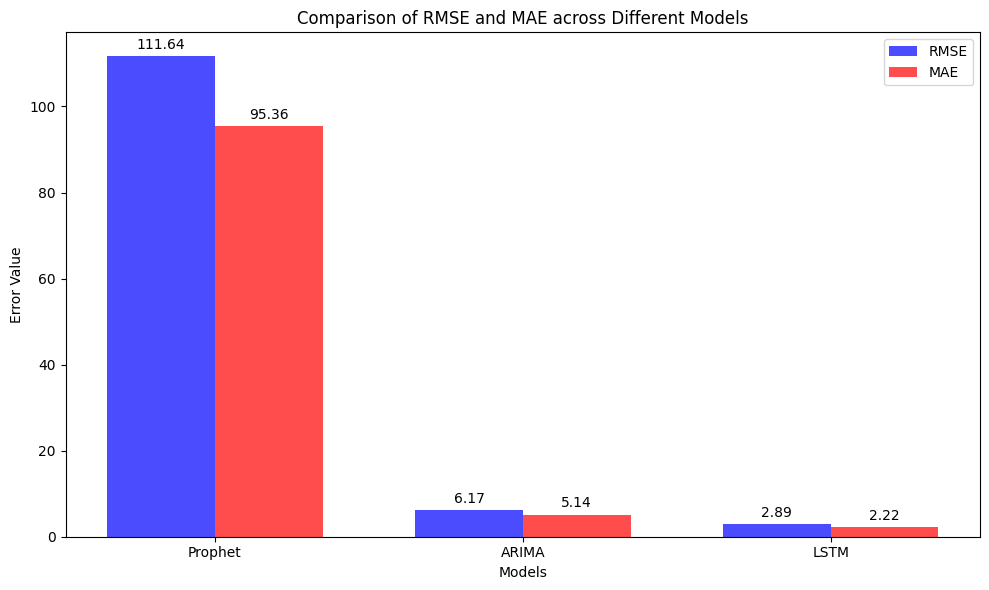

In [12]:
def plot_model_comparison(models, rmse_values, mae_values):
    """
    Plots a comparison of RMSE and MAE values across different models.
    
    Parameters:
    models (list of str): Names of the models.
    rmse_values (list of float): RMSE values for each model.
    mae_values (list of float): MAE values for each model.
    
    Returns:
    None
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    bar_width = 0.35
    index = np.arange(len(models))

    bar1 = ax.bar(index, rmse_values, bar_width, label='RMSE', color='b', alpha=0.7)
    bar2 = ax.bar(index + bar_width, mae_values, bar_width, label='MAE', color='r', alpha=0.7)

    ax.set_xlabel('Models')
    ax.set_ylabel('Error Value')
    ax.set_title('Comparison of RMSE and MAE across Different Models')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(models)
    ax.legend()

    # Display the values on the bars
    for rect in bar1 + bar2:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def main_plot_comparison(prophet_rmse, prophet_mae, arima_rmse, arima_mae, lstm_rmse, lstm_mae):
    """
    Main function to execute the RMSE and MAE comparison plot.
    
    Parameters:
    prophet_rmse, arima_rmse, lstm_rmse (float): RMSE values for Prophet, ARIMA, and LSTM models.
    prophet_mae, arima_mae, lstm_mae (float): MAE values for Prophet, ARIMA, and LSTM models.
    
    Returns:
    None
    """
    # Model names
models = ['Prophet', 'ARIMA', 'LSTM']

# RMSE and MAE values
rmse_values = [prophet_rmse, arima_rmse, lstm_rmse]
mae_values = [prophet_mae, arima_mae, lstm_mae]

# Plot the comparison
plot_model_comparison(models, rmse_values, mae_values)


In [13]:
def create_sequences(data, seq_length):
    """
    Creates sequences from time series data for LSTM input.

    Parameters:
    data (np.array): The input data.
    seq_length (int): The length of each sequence.

    Returns:
    tuple: Sequences (X) and corresponding targets (y).
    """
    X = []
    y = []
    # Loop over the dataset to create sequences of the specified length
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])  # Extract the sequence of length 'seq_length'
        y.append(data[i + seq_length, 0])  # Target value is the next value in the sequence (first feature)
    return np.array(X), np.array(y)  # Convert lists to numpy arrays


def time_series_cross_validation(data, seq_length=30, n_splits=5):
    """
    Performs time series cross-validation for LSTM model.

    Parameters:
    data (np.array): The input data.
    seq_length (int): The length of each sequence.
    n_splits (int): The number of cross-validation splits.

    Returns:
    tuple: Average RMSE and MAE scores across all splits.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)  # Initialize TimeSeriesSplit object for cross-validation
    rmse_scores = []  # List to store RMSE scores for each fold
    mae_scores = []   # List to store MAE scores for each fold
    
    # Loop over each fold in the cross-validation
    for train_index, val_index in tscv.split(data):
        train_data, val_data = data[train_index], data[val_index]  # Split data into training and validation sets
        X_train, y_train = create_sequences(train_data, seq_length)  # Create sequences for training
        X_val, y_val = create_sequences(val_data, seq_length)        # Create sequences for validation

        # Define the LSTM model architecture
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(seq_length, data.shape[1])))  # LSTM layer with 50 units
        model.add(Dense(1))  # Output layer with a single unit
        model.compile(optimizer='adam', loss='mse')  # Compile the model with Adam optimizer and MSE loss

        # Early stopping callback to prevent overfitting and save best model
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train the LSTM model on the training data with validation on validation set
        model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), 
                  verbose=1, callbacks=[early_stopping])

        # Make predictions on the validation set
        y_pred = model.predict(X_val)

        # Calculate RMSE and MAE for the current fold
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)

        # Append the calculated scores to the respective lists
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return the average RMSE and MAE scores across all folds
    return np.mean(rmse_scores), np.mean(mae_scores)


def run_lstm_cv_pipeline(filepath, columns, seq_length=30, n_splits=5):
    """
    Runs the LSTM cross-validation pipeline and returns evaluation metrics.

    Parameters:
    filepath (str): The path to the CSV file.
    columns (list of str): List of columns to include in the model.
    seq_length (int): The length of each sequence.
    n_splits (int): The number of cross-validation splits.

    Returns:
    tuple: Average RMSE and MAE scores across all splits.
    """
    # Load the dataset from the CSV file, parse dates, and set the 'DATE' column as the index
    daily_data = pd.read_csv(filepath, parse_dates=['DATE'], index_col='DATE')
    
    # Select the specified columns, convert to numeric values, and drop any rows with missing values
    data = daily_data[columns].apply(pd.to_numeric, errors='coerce').dropna().values
    
    # Perform cross-validation using the LSTM model
    lstm_rmse, lstm_mae = time_series_cross_validation(data, seq_length=seq_length, n_splits=n_splits)
    
    # Return the average RMSE and MAE scores
    return lstm_rmse, lstm_mae


# Run the LSTM cross-validation pipeline with the specified file path and columns
lstm_rmse, lstm_mae = run_lstm_cv_pipeline('Daily Summaries - GHCND.csv', columns=['TMAX', 'TMIN', 'PRCP', 'SNWD'])

# Print the results of cross-validation
print(f'LSTM Cross-Validation RMSE: {lstm_rmse:.2f}')
print(f'LSTM Cross-Validation MAE: {lstm_mae:.2f}')


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 55.6884 - val_loss: 7.2650
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1695 - val_loss: 5.8071
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2524 - val_loss: 5.5623
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6668 - val_loss: 5.4608
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5209 - val_loss: 5.3751
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3451 - val_loss: 5.6780
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3050 - val_loss: 5.2704
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4732 - val_loss: 5.3055
Epoch 9/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2309 - val_loss: 5.1995
Epoch 10/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4028 - val_loss: 5.2224
Epoch 11/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0557 - val_loss: 5.4130
Epoch 12/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4026 - val_l

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 14.1953 - val_loss: 4.1250
Epoch 2/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4616 - val_loss: 4.0166
Epoch 3/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4858 - val_loss: 4.5472
Epoch 4/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3983 - val_loss: 3.9848
Epoch 5/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3620 - val_loss: 4.0354
Epoch 6/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3732 - val_loss: 4.0142
Epoch 7/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.2635 - val_loss: 3.9863
Epoch 8/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.2081 - val_loss: 4.0341
Epoch 9/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3367 - val_loss: 3.9441
Epoch 10/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3755 - val_loss: 3.9646
Epoch 11/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.2688 - val_loss: 3.8976
Epoch 12/20


Reloading Tuner from bayesian_tuning/weather_forecast/tuner0.json
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step
      Parameter      RMSE       MAE
0          TMAX  2.868296  2.212443
1          TMIN  2.838441  2.166408
2          PRCP  5.307875  3.123499
3          SNWD  5.092840  0.998403
4  TMAX_ROLLING  1.497869  0.909283
5  TMIN_ROLLING  1.243949  0.671234
6  PRCP_ROLLING  1.314627  0.742082
7  SNWD_ROLLING  0.000882  0.000858
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

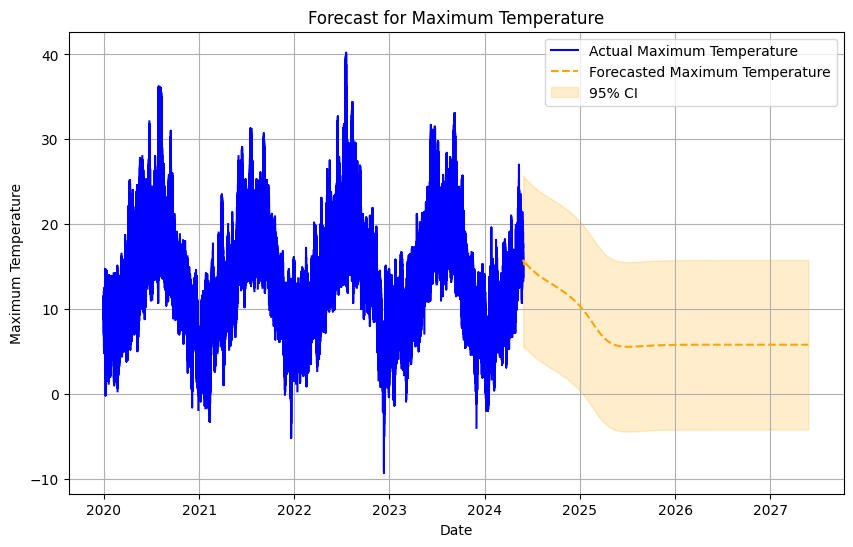

Plotting column: Minimum Temperature


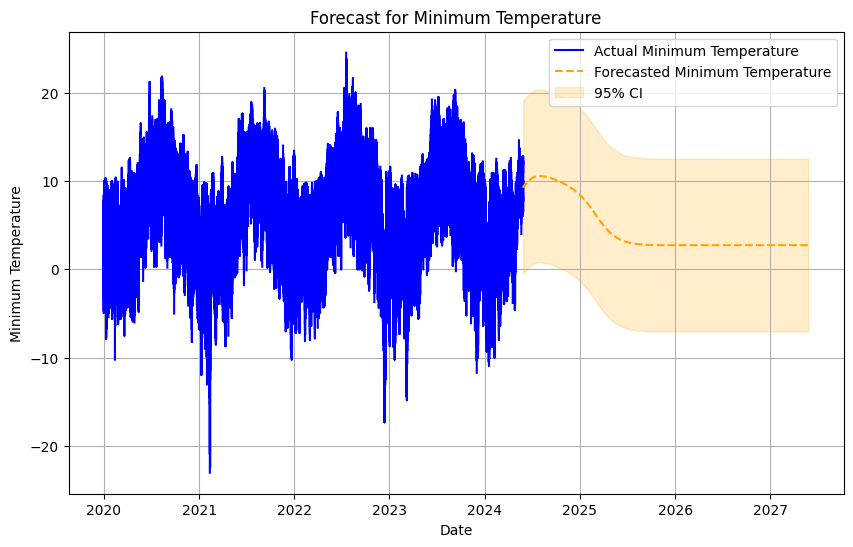

Plotting column: Precipitation


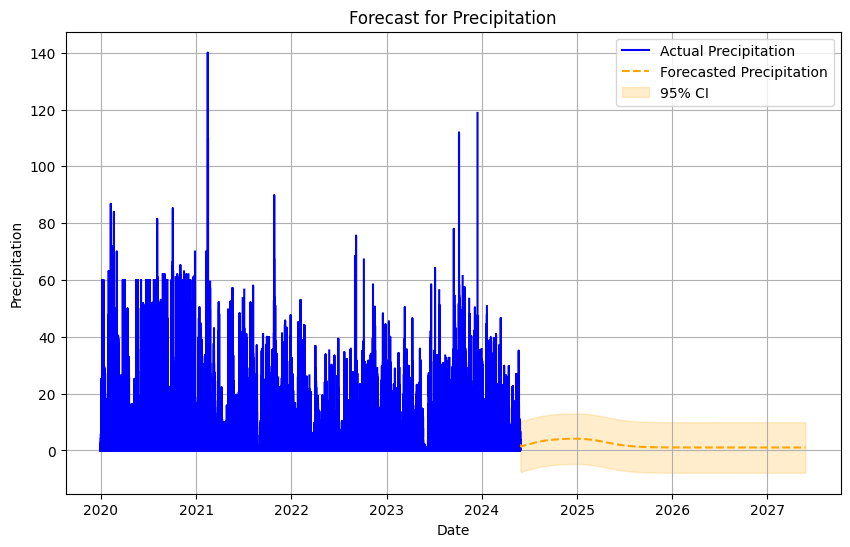

Plotting column: Snow Depth


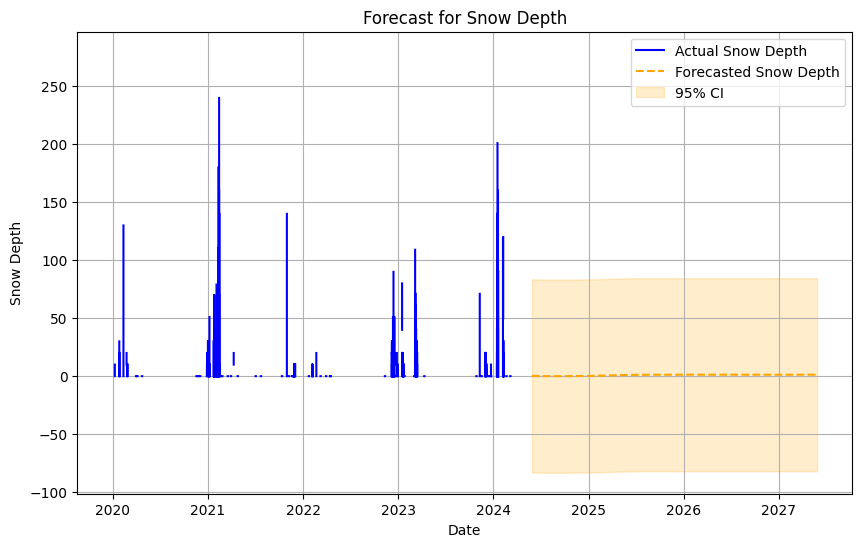

In [14]:
# Define the column names mapping for readability in plots and reports
COLUMN_NAMES = {
    'daily': ['Maximum Temperature', 'Minimum Temperature', 'Precipitation', 'Snow Depth', 
              '7-Day Rolling Maximum Temperature', '7-Day Rolling Minimum Temperature', 
              '7-Day Rolling Precipitation', '7-Day Rolling Snow Depth']
}

def load_and_preprocess_data(filepath):
    """
    Load and preprocess the data.

    Parameters:
    - filepath: str, the path to the CSV file containing the data.

    Returns:
    - scaled_data: np.ndarray, the scaled feature data.
    - scaler: MinMaxScaler object, the scaler used to normalize the data.
    - columns: list, the names of the columns in the data.
    - daily_data: pd.DataFrame, the original daily data with added rolling features.
    """
    # Load data from CSV, parse dates, and set the 'DATE' column as the index
    daily_data = pd.read_csv(filepath, parse_dates=['DATE'], index_col='DATE')
    daily_data = daily_data.sort_index() 
    
    # Feature engineering: Adding rolling averages for key features (7-day rolling window)
    daily_data['TMAX_ROLLING'] = daily_data['TMAX'].rolling(window=7).mean()
    daily_data['TMIN_ROLLING'] = daily_data['TMIN'].rolling(window=7).mean()
    daily_data['PRCP_ROLLING'] = daily_data['PRCP'].rolling(window=7).mean()
    daily_data['SNWD_ROLLING'] = daily_data['SNWD'].rolling(window=7).mean()
    
    # Define the columns to be used in the model
    columns = ['TMAX', 'TMIN', 'PRCP', 'SNWD', 'TMAX_ROLLING', 'TMIN_ROLLING', 'PRCP_ROLLING', 'SNWD_ROLLING']
    
    # Convert data to numeric and handle missing values by filling with the median
    data = daily_data[columns].apply(pd.to_numeric, errors='coerce')
    data = data.fillna(data.median())
    
    # Normalize the data using MinMaxScaler to ensure all features are on a similar scale
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    return scaled_data, scaler, columns, daily_data

def create_sequences(data, seq_length=30):
    """
    Create sequences of data for LSTM input.

    Parameters:
    - data: np.ndarray, the scaled feature data.
    - seq_length: int, the length of each sequence.

    Returns:
    - X: np.ndarray, the input sequences.
    - y: np.ndarray, the corresponding target values.
    """
    X, y = [], []
    # Loop through the dataset to create sequences of specified length
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Sequence of length 'seq_length'
        y.append(data[i+seq_length])    # Target value is the next point after the sequence
    return np.array(X), np.array(y)

def build_model(hp, input_shape):
    """
    Build and compile a Bidirectional LSTM model.

    Parameters:
    - hp: HyperParameters object, for tuning the model.
    - input_shape: tuple, the shape of the input data.

    Returns:
    - model: Sequential model, the compiled LSTM model.
    """
    model = Sequential()
    # Add a Bidirectional LSTM layer with tunable units and return sequences for stacking
    model.add(Bidirectional(LSTM(units=hp.Int('units1', min_value=32, max_value=256, step=32), 
                                 return_sequences=True), input_shape=input_shape))
    # Add Dropout layer to prevent overfitting with tunable dropout rate
    model.add(Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Add a second LSTM layer with tunable units
    model.add(LSTM(units=hp.Int('units2', min_value=32, max_value=256, step=32)))
    
    # Dropout layer for regularization
    model.add(Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))  
    
    # Output layer: Dense layer with the number of outputs equal to the number of features
    model.add(Dense(input_shape[1]))  # Output layer for all features
    
    # Compile the model with a tunable learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])),
                  loss='mean_squared_error')
    return model

def tune_and_train_model(X_train, y_train, input_shape):
    """
    Tune and train the LSTM model using Bayesian Optimization.

    Parameters:
    - X_train: np.ndarray, training input sequences.
    - y_train: np.ndarray, training target values.
    - input_shape: tuple, the shape of the input data.

    Returns:
    - best_model: Sequential model, the best trained LSTM model.
    """
    # Initialize Bayesian Optimization tuner
    tuner = BayesianOptimization(
        lambda hp: build_model(hp, input_shape),  # Pass build_model as a lambda function
        objective='val_loss',  # Optimization objective
        max_trials=15,  # Number of different hyperparameter combinations to try
        executions_per_trial=2,  # Number of executions per trial to reduce variability
        directory='bayesian_tuning',  # Directory to save tuning results
        project_name='weather_forecast')
    
    # Define early stopping callback to prevent overfitting and unnecessary training
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Perform hyperparameter search
    tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping])
    
    # Retrieve the best model found during the search
    best_model = tuner.get_best_models(num_models=1)[0]
    return best_model

def predict_future(model, data, scaler, seq_length, num_features, steps=1095):
    """
    Predict future values using the trained model.

    Parameters:
    - model: Sequential model, the trained LSTM model.
    - data: np.ndarray, the scaled feature data.
    - scaler: MinMaxScaler object, the scaler used to normalize the data.
    - seq_length: int, the length of each sequence.
    - num_features: int, the number of features in the data.
    - steps: int, the number of future steps to predict.

    Returns:
    - future_predictions_actual: np.ndarray, the predicted future values in the original scale.
    """
    # Start with the last sequence of the training data
    last_sequence = data[-seq_length:]
    future_predictions = []

    # Generate predictions for the specified number of future steps
    for _ in range(steps):
        # Predict the next value using the model
        prediction = model.predict(last_sequence.reshape(1, seq_length, num_features))
        future_predictions.append(prediction[0])
        # Update the sequence with the predicted value
        last_sequence = np.append(last_sequence[1:], prediction, axis=0)

    # Inverse transform the predictions to their original scale
    future_predictions = np.array(future_predictions)
    future_predictions_actual = scaler.inverse_transform(future_predictions)
    return future_predictions_actual

def calculate_metrics(y_test, y_pred, columns):
    """
    Calculate and print RMSE and MAE metrics for the test set.

    Parameters:
    - y_test: np.ndarray, the actual test set values.
    - y_pred: np.ndarray, the predicted test set values.
    - columns: list, the names of the columns being predicted.
    """
    # Calculate RMSE and MAE for each feature in the test set
    rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
    mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    
    # Create a DataFrame to store and display the metrics for each feature
    metrics_df = pd.DataFrame({
        'Parameter': columns,
        'RMSE': rmse,
        'MAE': mae
    })
    
    # Print the metrics
    print(metrics_df)
    
def plot_predictions(daily_data, future_predictions, future_dates, columns, ci_multiplier=1.96):
    """
    Plot actual vs forecasted data with confidence intervals.

    Parameters:
    - daily_data: pd.DataFrame, the actual historical data.
    - future_predictions: np.ndarray, the predicted future values.
    - future_dates: pd.DatetimeIndex, the future dates corresponding to the predictions.
    - columns: list, the names of the columns being predicted.
    - ci_multiplier: float, the multiplier for the confidence interval (default is 1.96 for 95% CI).
    """
    # Filter out rolling columns since they are derived features
    non_rolling_columns = [col for col in columns if 'ROLLING' not in col]
    
    for i, col in enumerate(non_rolling_columns):
        plt.figure(figsize=(10, 6))

        # Use COLUMN_NAMES to get full names for the columns
        full_col_name = COLUMN_NAMES['daily'][columns.index(col)]
        print("Plotting column:", full_col_name)  # Debugging statement

        # Plot actual historical data
        plt.plot(daily_data.index, daily_data[col], label='Actual ' + full_col_name, color='blue')

        # Plot forecasted data
        plt.plot(future_dates, future_predictions[:, i], label='Forecasted ' + full_col_name, linestyle='dashed', color='orange')

        # Calculate standard deviation of residuals for confidence interval
        residuals = daily_data[col][-len(future_predictions):] - future_predictions[:, i]
        residual_std = residuals.std()

        # Calculate the confidence interval bounds
        lower_bound = future_predictions[:, i] - ci_multiplier * residual_std
        upper_bound = future_predictions[:, i] + ci_multiplier * residual_std

        # Plot the confidence interval
        plt.fill_between(future_dates, lower_bound, upper_bound, color='orange', alpha=0.2, label='95% CI')

        plt.title(f'Forecast for {full_col_name}')
        plt.xlabel('Date')
        plt.ylabel(full_col_name)
        plt.legend()
        plt.grid(True)
        plt.show()

def main():
    """
    Main function to load data, train the LSTM model, predict future values, and plot results.
    """
    # Filepath for the dataset
    filepath = 'Daily Summaries - GHCND.csv'
    seq_length = 30  # Length of sequences for LSTM input

    # Load and preprocess data
    scaled_data, scaler, columns, daily_data = load_and_preprocess_data(filepath)
    
    # Create input sequences and corresponding target values for LSTM
    X, y = create_sequences(scaled_data, seq_length)
    
    # Split data into train and test sets (80-20 split)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Define input shape for the model
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Tune hyperparameters and train the LSTM model
    model = tune_and_train_model(X_train, y_train, input_shape)
    
    # Make predictions on the test set and inverse transform to original scale
    y_pred_scaled = model.predict(X_test)
    y_pred_actual = scaler.inverse_transform(y_pred_scaled)
    y_test_actual = scaler.inverse_transform(y_test)
    
    # Calculate RMSE and MAE for the test set predictions
    calculate_metrics(y_test_actual, y_pred_actual, columns)
    
    # Predict the next 3 years (1095 days) using the trained model
    future_predictions = predict_future(model, scaled_data, scaler, seq_length, num_features=scaled_data.shape[1], steps=1095)
    
    # Generate future dates for plotting
    future_dates = pd.date_range(start=daily_data.index[-1], periods=1095, freq='D')
    
    print("Columns used for predictions:", columns)
    
    # Plot actual and forecasted data with confidence intervals
    plot_predictions(daily_data, future_predictions, future_dates, columns)

if __name__ == "__main__":
    main()
